# YOLO Training

## Reqirements

In [ ]:
!pip install pylabel

In [ ]:
!pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.8/486.8 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 KB 22.4 MB/s eta 0:00:00


In [ ]:
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 KB 5.2 MB/s eta 0:00:00


In [ ]:
!pip install funcy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.13.1+cu116 True


## Load Data

In [ ]:
!wget https://s3.amazonaws.com/ifashionist-dataset/images/train2020.zip
!wget https://s3.amazonaws.com/ifashionist-dataset/annotations/instances_attributes_train2020.json
!unzip /content/train2020.zip -d dataset/

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/52376f1a6cd1f67eddc517b11242960b.jpg  
  inflating: dataset/train/236f5f6a3d70aebe9807ee1cdb00a26a.jpg  
  inflating: dataset/train/bc3f324781cb94d7632fb449857645d5.jpg  
  inflating: dataset/train/febafb43e0a8a5a62bd64d0e1e2c51bb.jpg  
  inflating: dataset/train/62f7105882625f0ea9c43639cc450af2.jpg  
  inflating: dataset/train/bbaaed6a5643083d11db6c6839ce162c.jpg  
  inflating: dataset/train/1127d6d9a4ad34e3f6ea6abfed23fadf.jpg  
  inflating: dataset/train/dc8e143844a77f42337c7f6d1a83f0a9.jpg  
  inflating: dataset/train/2ab1eb6b641df05b18bbcd31546f41c3.jpg  
  inflating: dataset/train/39c5ccb6ae593374c065719c46b14cb7.jpg  
  inflating: dataset/train/20c4c3ee365b7b8b9b813176899d8bcc.jpg  
  inflating: dataset/train/43929c91575dc1d8a0aebc4f5ac7592d.jpg  
  inflating: dataset/train/c3045c901c4c91d7564a3407d351d1b5.jpg  
  inflating: dataset/train/fe6bdd2397004cd9be166166626d42ba.jpg  
  inflating: dataset/trai

In [ ]:
!wget https://s3.amazonaws.com/ifashionist-dataset/images/val_test2020.zip
!wget https://s3.amazonaws.com/ifashionist-dataset/annotations/instances_attributes_val2020.json
!unzip /content/val_test2020.zip -d dataset/

--2023-03-29 12:31:37--  https://s3.amazonaws.com/ifashionist-dataset/images/val_test2020.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.104.78, 52.217.170.224, 52.216.62.64, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.104.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 236499034 (226M) [application/zip]
Saving to: ‘val_test2020.zip’

val_test2020.zip    100%[===================>] 225.54M  42.5MB/s    in 5.8s    

2023-03-29 12:31:43 (38.7 MB/s) - ‘val_test2020.zip’ saved [236499034/236499034]

--2023-03-29 12:31:43--  https://s3.amazonaws.com/ifashionist-dataset/annotations/instances_attributes_val2020.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.172.32, 52.216.232.69, 54.231.226.8, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.172.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14533475 (14M) [application/json]
Saving to: ‘instances_attributes_val2020.json’

instance

## Splitting

In [ ]:
from skmultilearn.model_selection import IterativeStratification

def iterative_train_test_split(X, y, test_size, random_state):
    """Iteratively stratified train/test split

    Parameters
    ----------
    test_size : float, [0,1]
        the proportion of the dataset to include in the test split, the rest will be put in the train set

    Returns
    -------
    X_train, y_train, X_test, y_test
        stratified division into train/test split
    """

    stratifier = IterativeStratification(n_splits=2, order=2, sample_distribution_per_fold=[test_size, 1.0-test_size], random_state=random_state)
    train_indexes, test_indexes = next(stratifier.split(X, y))

    X_train, y_train = X[train_indexes, :], y[train_indexes, :]
    X_test, y_test = X[test_indexes, :], y[test_indexes, :]

    return X_train, y_train, X_test, y_test

In [ ]:
import json
import argparse
import funcy
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split
import numpy as np


def save_coco(file, info, licenses, images, annotations, categories):
    with open(file, 'wt', encoding='UTF-8') as coco:
        json.dump({ 'info': info, 'licenses': licenses, 'images': images, 
            'annotations': annotations, 'categories': categories}, coco, indent=2, sort_keys=True)

def filter_annotations(annotations, images):
    image_ids = funcy.lmap(lambda i: int(i['id']), images)
    return funcy.lfilter(lambda a: int(a['image_id']) in image_ids, annotations)


def filter_images(images, annotations):

    annotation_ids = funcy.lmap(lambda i: int(i['image_id']), annotations)

    return funcy.lfilter(lambda a: int(a['id']) in annotation_ids, images)



def split_data(annots, having_annotations, multi_class, split, train, test):

    with open(annots, 'rt', encoding='UTF-8') as annotations:
        coco = json.load(annotations)
        info = coco['info']
        licenses = coco['licenses']
        images = coco['images']
        annotations = coco['annotations']
        categories = coco['categories']

        number_of_images = len(images)

        images_with_annotations = funcy.lmap(lambda a: int(a['image_id']), annotations)

        if having_annotations:
            images = funcy.lremove(lambda i: i['id'] not in images_with_annotations, images)


        if multi_class:

            annotation_categories = funcy.lmap(lambda a: int(a['category_id']), annotations)

            #bottle neck 1
            #remove classes that has only one sample, because it can't be split into the training and testing sets
            # annotation_categories =  funcy.lremove(lambda i: annotation_categories.count(i) <=1  , annotation_categories)

            # annotations =  funcy.lremove(lambda i: i['category_id'] not in annotation_categories  , annotations)

            print(np.array([annotation_categories]).T.shape)
            print(np.array([annotations]).T.shape)
            X_train, y_train, X_test, y_test = iterative_train_test_split(np.array([annotations]).T,np.array([ annotation_categories]).T, test_size = 1-split, random_state=78)

            save_coco(train, info, licenses, filter_images(images, X_train.reshape(-1)), X_train.reshape(-1).tolist(), categories)
            # save_coco(test, info, licenses,  filter_images(images, X_test.reshape(-1)), X_test.reshape(-1).tolist(), categories)

            print("Saved {} entries in {} and {} in {}".format(len(X_train), train, len(X_test), test))
            
        else:

            X_train, X_test = train_test_split(images, train_size=split)

            anns_train = filter_annotations(annotations, X_train)
            # anns_test=filter_annotations(annotations, X_test)
            anns_test = []

            save_coco(train, info, licenses, X_train, anns_train, categories)
            # save_coco(test, info, licenses, X_test, anns_test, categories)

            print("Saved {} entries in {} and {} in {}".format(len(anns_train), train, len(anns_test), test))

In [ ]:
split_data(annots='/content/instances_attributes_train2020.json', having_annotations=False, multi_class=True, split=0.1, train='train_annots.json', test='test.json')

In [ ]:
import json

with open('/content/instances_attributes_train2020.json', 'rt', encoding='UTF-8') as annotations:
  coco = json.load(annotations)

In [ ]:
for img in coco['images']:
  if [img['id']] in [[16305],[20443]]:
    print(img)
    break

{'id': 16305, 'width': 680, 'height': 1024, 'file_name': '2f10b4d61e445fe5d0777723630a2905.jpg', 'license': 5, 'time_captured': 'March-August, 2018', 'original_url': 'http://farm4.staticflickr.com/3692/11453231775_f3a4bf9ca3_n.jpg', 'isstatic': 1, 'kaggle_id': '2f10b4d61e445fe5d0777723630a2905'}


In [ ]:
import pandas as pd

anns = pd.json_normalize(coco['annotations'])
anns

,image_id,category_id,attribute_ids,segmentation,bbox,area,iscrowd,id,segmentation.size,segmentation.counts
0,16305,32,[218],"[[471, 390, 461, 412, 457, 430, 454, 455, 454,...","[454.0, 390.0, 46.0, 109.0]",3052,0,0,NaN,NaN
1,16305,31,"[204, 205, 159]","[[334, 329, 344, 307, 348, 293, 354, 282, 365,...","[271.0, 133.0, 98.0, 223.0]",12906,0,1,NaN,NaN
2,16305,31,"[205, 159]","[[522, 331, 523, 355, 515, 376, 510, 382, 512,...","[482.0, 323.0, 74.0, 169.0]",5794,0,2,NaN,NaN
3,16305,22,[],"[[348, 745, 356, 731, 364, 719, 376, 704, 392,...","[322.0, 658.0, 208.0, 112.0]",3838,0,3,NaN,NaN
4,16305,22,[],"[[466, 771, 483, 765, 489, 762, 492, 758, 494,...","[405.0, 749.0, 97.0, 213.0]",9415,0,4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
333396,27491,1,"[295, 136, 16, 145, 147, 115, 316, 317]","[[171, 357, 189, 344, 214, 333, 227, 363, 230,...","[149.0, 26.0, 515.0, 920.0]",264997,0,333396,NaN,NaN
333397,4744,21,[],"[[424, 603, 424, 621, 429, 652, 428, 655, 429,...","[424.0, 603.0, 34.0, 65.0]",1354,0,333397,NaN,NaN
333398,4744,21,[],"[[491, 658, 491, 654, 492, 652, 492, 642, 488,...","[488.0, 605.0, 36.0, 60.0]",1447,0,333398,NaN,NaN
333399,4744,23,[],"[[429, 681, 428, 673, 426, 666, 428, 664, 429,...","[426.0, 662.0, 31.0, 19.0]",426,0,333399,NaN,NaN


In [ ]:
anns

NameError: ignored

In [ ]:
a = anns.groupby('image_id')
a.first()

In [ ]:
out = anns[['category_id']].agg(list,1).groupby(anns['image_id'],sort=False).sum().to_frame('category').reset_index()

In [ ]:
out

,image_id,category
0,16305,"[32, 31, 31, 22, 22, 28, 0]"
1,18875,"[31, 28, 31, 10, 0, 23, 23]"
2,20443,"[28, 32, 32, 32, 31, 31, 10, 21, 21, 23, 23]"
3,15157,"[10, 13, 19, 24, 33]"
4,15165,"[23, 23, 6, 32, 32, 0, 31, 31, 27]"
...,...,...
45618,27458,"[10, 33, 44, 44, 44, 44]"
45619,27476,"[13, 10, 33, 3, 31, 31, 24]"
45620,27485,"[4, 31, 31, 29]"
45621,27491,"[31, 31, 27, 1]"


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
df = pd.DataFrame(mlb.fit_transform(out['category']),columns=mlb.classes_)

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45618,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
45619,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45620,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45621,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(out['image_id'].to_numpy().reshape(-1, 1))

[[16305]
 [18875]
 [20443]
 ...
 [27485]
 [27491]
 [ 4744]]


In [ ]:
print(df.to_numpy().reshape(-1, 46)[0])

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
from skmultilearn.model_selection import iterative_train_test_split

X_train, y_train, X_test, y_test = iterative_train_test_split(out['image_id'].to_numpy().reshape(-1, 1),df.to_numpy().reshape(-1, 46), test_size = 0.9)


In [ ]:
X_train

array([[16305],
       [18875],
       [20443],
       ...,
       [26689],
       [26740],
       [26749]])

In [ ]:
out[out['image_id'].isin(X_train.reshape(-1,))]

,image_id,category
0,16305,"[32, 31, 31, 22, 22, 28, 0]"
1,18875,"[31, 28, 31, 10, 0, 23, 23]"
2,20443,"[28, 32, 32, 32, 31, 31, 10, 21, 21, 23, 23]"
3,15157,"[10, 13, 19, 24, 33]"
5,15567,"[10, 33, 13, 31, 30, 30, 28, 31, 31, 24, 24, 2..."
...,...,...
45247,24642,"[31, 31, 33, 10, 21, 21, 22, 22, 23, 23, 16]"
45466,26343,"[6, 19]"
45520,26689,"[3, 33, 1, 6]"
45530,26740,"[3, 33]"


In [ ]:
y_train

(4697, 46)

In [ ]:
print(coco['annotations'][0])

{'image_id': 16305, 'category_id': 32, 'attribute_ids': [218], 'segmentation': [[471, 390, 461, 412, 457, 430, 454, 455, 454, 473, 457, 483, 469, 489, 477, 492, 485, 498, 493, 499, 499, 496, 500, 490, 494, 479, 487, 461, 485, 445, 483, 434, 487, 433, 489, 426, 489, 412, 484, 403, 480, 395, 477, 392]], 'bbox': [454.0, 390.0, 46.0, 109.0], 'area': 3052, 'iscrowd': 0, 'id': 0}


In [ ]:
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import json

def save_as_coco(X, coco, file):
  temp_img = []
  temp_annot = []
  for img in coco['images']:
      if [img['id']] in X:
        temp_img.append(img)
  for annot in coco['annotations']:
    if [annot['image_id']] in X:
      temp_annot.append(annot)
  with open(file, 'wt', encoding='UTF-8') as c_file:
        json.dump({ 'info': coco['info'], 'licenses': coco['licenses'], 'images': temp_img, 
            'annotations': temp_annot, 'categories': coco['categories']}, c_file, indent=2, sort_keys=True)


def stratified_split(annot_file, train_file, val_file, train_size, val_size):
  with open(annot_file, 'rt', encoding='UTF-8') as annotations:
    coco = json.load(annotations)
  anns = pd.json_normalize(coco['annotations'])
  cat_num = len(pd.json_normalize(coco['categories']))
  print(str_format('NUMBER OF CATEGORIES : ', fore='sky'), cat_num)
  grouped = anns[['category_id']].agg(list,1).groupby(anns['image_id'],sort=False).sum().to_frame('category').reset_index()
  print(str_format('CATEGORIES GROUPED BY IMAGE ID DATAFRAME HEAD  :  ', fore='g'))
  print(grouped.head())
  mlb = MultiLabelBinarizer()
  one_hot = pd.DataFrame(mlb.fit_transform(grouped['category']),columns=mlb.classes_)
  X_train, y_train, X_rest, y_rest = iterative_train_test_split(grouped['image_id'].to_numpy().reshape(-1, 1),one_hot.to_numpy().reshape(-1, cat_num), test_size= 1 - train_size)
  grouped = grouped[grouped['image_id'].isin(X_rest.reshape(-1,))]
  one_hot = pd.DataFrame(mlb.fit_transform(grouped['category']),columns=mlb.classes_)
  X_val, y_val, X_test, y_test = iterative_train_test_split(grouped['image_id'].to_numpy().reshape(-1, 1),one_hot.to_numpy().reshape(-1, cat_num), test_size= 1-(val_size/(1 - train_size)))
  print(str_format('Train size : ', fore='sky'), len(X_train))
  print(str_format('Val size : ', fore='sky'), len(X_val))
  print(str_format('Test size : ', fore='sky'), len(X_test))
  print(str_format('START SAVING JSON FILES ...', fore='y'))
  save_as_coco(X_train, coco, train_file)
  save_as_coco(X_val, coco, val_file)
  print(str_format('DONE', fore='g'))

In [ ]:
stratified_split('/content/instances_attributes_train2020.json', 'train_split_annot.json', 'val_split_annot.json', 0.15, 0.03)

NUMBER OF CATEGORIES :  46
CATEGORIES GROUPED BY IMAGE ID DATAFRAME HEAD  :  
   image_id                                      category
0     16305                   [32, 31, 31, 22, 22, 28, 0]
1     18875                   [31, 28, 31, 10, 0, 23, 23]
2     20443  [28, 32, 32, 32, 31, 31, 10, 21, 21, 23, 23]
3     15157                          [10, 13, 19, 24, 33]
4     15165            [23, 23, 6, 32, 32, 0, 31, 31, 27]
Train size :  6865
Val size :  1535
Test size :  37223
START SAVING JSON FILES ...
DONE


## Filter categories

In [ ]:
import json
from pathlib import Path

class CocoFilter():
    """ Filters the COCO dataset
    """
    def _process_info(self):
        self.info = self.coco['info']
        
    # def _process_licenses(self):
    #     self.licenses = self.coco['licenses']
        
    def _process_categories(self):
        self.categories = dict()
        self.super_categories = dict()
        self.category_set = set()

        for category in self.coco['categories']:
            cat_id = category['id']
            super_category = category['supercategory']
            
            # Add category to categories dict
            if cat_id not in self.categories:
                self.categories[cat_id] = category
                self.category_set.add(category['name'])
            else:
                print(f'ERROR: Skipping duplicate category id: {category}')
            
            # Add category id to the super_categories dict
            if super_category not in self.super_categories:
                self.super_categories[super_category] = {cat_id}
            else:
                self.super_categories[super_category] |= {cat_id} # e.g. {1, 2, 3} |= {4} => {1, 2, 3, 4}

    def _process_images(self):
        self.images = dict()
        for image in self.coco['images']:
            image_id = image['id']
            if image_id not in self.images:
                self.images[image_id] = image
            else:
                print(f'ERROR: Skipping duplicate image id: {image}')
                
    def _process_segmentations(self):
        self.segmentations = dict()
        for segmentation in self.coco['annotations']:
            image_id = segmentation['image_id']
            if image_id not in self.segmentations:
                self.segmentations[image_id] = []
            self.segmentations[image_id].append(segmentation)

    def _filter_categories(self):
        """ Find category ids matching args
            Create mapping from original category id to new category id
            Create new collection of categories
        """
        missing_categories = set(self.filter_categories) - self.category_set
        if len(missing_categories) > 0:
            print(f'Did not find categories: {missing_categories}')
            should_continue = input('Continue? (y/n) ').lower()
            if should_continue != 'y' and should_continue != 'yes':
                print('Quitting early.')
                quit()

        self.new_category_map = dict()
        new_id = 1
        for key, item in self.categories.items():
            if item['name'] in self.filter_categories:
                self.new_category_map[key] = new_id
                new_id += 1

        self.new_categories = []
        for original_cat_id, new_id in self.new_category_map.items():
            new_category = dict(self.categories[original_cat_id])
            new_category['id'] = new_id
            self.new_categories.append(new_category)

    def _filter_annotations(self):
        """ Create new collection of annotations matching category ids
            Keep track of image ids matching annotations
        """
        self.new_segmentations = []
        self.new_image_ids = set()
        for image_id, segmentation_list in self.segmentations.items():
            for segmentation in segmentation_list:
                original_seg_cat = segmentation['category_id']
                if original_seg_cat in self.new_category_map.keys():
                    new_segmentation = dict(segmentation)
                    new_segmentation['category_id'] = self.new_category_map[original_seg_cat]
                    self.new_segmentations.append(new_segmentation)
                    self.new_image_ids.add(image_id)

    def _filter_images(self):
        """ Create new collection of images
        """
        self.new_images = []
        for image_id in self.new_image_ids:
            self.new_images.append(self.images[image_id])

    def main(self, input_json, output_json, categories):
        # Open json
        self.input_json_path = Path(input_json)
        self.output_json_path = Path(output_json)
        self.filter_categories = categories

        # Verify input path exists
        if not self.input_json_path.exists():
            print('Input json path not found.')
            print('Quitting early.')
            quit()

        # Verify output path does not already exist
        if self.output_json_path.exists():
            should_continue = input('Output path already exists. Overwrite? (y/n) ').lower()
            if should_continue != 'y' and should_continue != 'yes':
                print('Quitting early.')
                quit()
        
        # Load the json
        print('Loading json file...')
        with open(self.input_json_path) as json_file:
            self.coco = json.load(json_file)
        
        # Process the json
        print('Processing input json...')
        self._process_info()
        # self._process_licenses()
        self._process_categories()
        self._process_images()
        self._process_segmentations()

        # Filter to specific categories
        print('Filtering...')
        self._filter_categories()
        self._filter_annotations()
        self._filter_images()

        # Build new JSON
        new_master_json = {
            'info': self.info,
            # 'licenses': self.licenses,
            'images': self.new_images,
            'annotations': self.new_segmentations,
            'categories': self.new_categories
        }

        # Write the JSON to a file
        print('Saving new json file...')
        with open(self.output_json_path, 'w+') as output_file:
            json.dump(new_master_json, output_file)

        print('Filtered json saved.')


In [ ]:
cf = CocoFilter()

In [ ]:
cf.main('/content/train_split_annot.json', 'filtered_train_annotations.json', ['pants', 'shirt, blouse', 'top, t-shirt, sweatshirt', 'jacket', 'dress', 'glasses', 'shoe', 'bag, wallet', 'hat', 'watch'])

Loading json file...
Processing input json...
Filtering...
Saving new json file...
Filtered json saved.


In [ ]:
cf.main('/content/val_split_annot.json', 'filtered_test_annotations.json', ['pants', 'shirt, blouse', 'top, t-shirt, sweatshirt', 'jacket', 'dress', 'glasses', 'shoe', 'bag, wallet', 'hat', 'watch'])

Loading json file...
Processing input json...
Filtering...
Saving new json file...
Filtered json saved.


## COCO To YOLO

In [ ]:
import glob
import os
import shutil
from pathlib import Path

import numpy as np
from PIL import ExifTags
from tqdm import tqdm

# Parameters
img_formats = ['bmp', 'jpg', 'jpeg', 'png', 'tif', 'tiff', 'dng']  # acceptable image suffixes
vid_formats = ['mov', 'avi', 'mp4', 'mpg', 'mpeg', 'm4v', 'wmv', 'mkv']  # acceptable video suffixes

# Get orientation exif tag
for orientation in ExifTags.TAGS.keys():
    if ExifTags.TAGS[orientation] == 'Orientation':
        break


def exif_size(img):
    # Returns exif-corrected PIL size
    s = img.size  # (width, height)
    try:
        rotation = dict(img._getexif().items())[orientation]
        if rotation in [6, 8]:  # rotation 270
            s = (s[1], s[0])
    except:
        pass

    return s


def split_rows_simple(file='../data/sm4/out.txt'):  # from utils import *; split_rows_simple()
    # splits one textfile into 3 smaller ones based upon train, test, val ratios
    with open(file) as f:
        lines = f.readlines()

    s = Path(file).suffix
    lines = sorted(list(filter(lambda x: len(x) > 0, lines)))
    i, j, k = split_indices(lines, train=0.9, test=0.1, validate=0.0)
    for k, v in {'train': i, 'test': j, 'val': k}.items():  # key, value pairs
        if v.any():
            new_file = file.replace(s, f'_{k}{s}')
            with open(new_file, 'w') as f:
                f.writelines([lines[i] for i in v])


def split_files(out_path, file_name, prefix_path=''):  # split training data
    file_name = list(filter(lambda x: len(x) > 0, file_name))
    file_name = sorted(file_name)
    i, j, k = split_indices(file_name, train=0.9, test=0.1, validate=0.0)
    datasets = {'train': i, 'test': j, 'val': k}
    for key, item in datasets.items():
        if item.any():
            with open(f'{out_path}_{key}.txt', 'a') as file:
                for i in item:
                    file.write('%s%s\n' % (prefix_path, file_name[i]))


def split_indices(x, train=0.9, test=0.1, validate=0.0, shuffle=True):  # split training data
    n = len(x)
    v = np.arange(n)
    if shuffle:
        np.random.shuffle(v)

    i = round(n * train)  # train
    j = round(n * test) + i  # test
    k = round(n * validate) + j  # validate
    return v[:i], v[i:j], v[j:k]  # return indices


def make_dirs(dir=dir):
    # Create folders
    dir = Path(dir)
    if dir.exists():
        shutil.rmtree(dir)  # delete dir
    for p in dir, dir / 'labels', dir / 'images':
        p.mkdir(parents=True, exist_ok=True)  # make dir
    return dir


def write_data_data(fname='data.data', nc=80):
    # write darknet *.data file
    lines = ['classes = %g\n' % nc,
             'train =../out/data_train.txt\n',
             'valid =../out/data_test.txt\n',
             'names =../out/data.names\n',
             'backup = backup/\n',
             'eval = coco\n']

    with open(fname, 'a') as f:
        f.writelines(lines)


def image_folder2file(folder='images/'):  # from utils import *; image_folder2file()
    # write a txt file listing all imaged in folder
    s = glob.glob(f'{folder}*.*')
    with open(f'{folder[:-1]}.txt', 'w') as file:
        for l in s:
            file.write(l + '\n')  # write image list


def add_coco_background(path='../data/sm4/', n=1000):  # from utils import *; add_coco_background()
    # add coco background to sm4 in outb.txt
    p = f'{path}background'
    if os.path.exists(p):
        shutil.rmtree(p)  # delete output folder
    os.makedirs(p)  # make new output folder

    # copy images
    for image in glob.glob('../coco/images/train2014/*.*')[:n]:
        os.system(f'cp {image} {p}')

    # add to outb.txt and make train, test.txt files
    f = f'{path}out.txt'
    fb = f'{path}outb.txt'
    os.system(f'cp {f} {fb}')
    with open(fb, 'a') as file:
        file.writelines(i + '\n' for i in glob.glob(f'{p}/*.*'))
    split_rows_simple(file=fb)


def create_single_class_dataset(path='../data/sm3'):  # from utils import *; create_single_class_dataset('../data/sm3/')
    # creates a single-class version of an existing dataset
    os.system(f'mkdir {path}_1cls')


def flatten_recursive_folders(path='../../Downloads/data/sm4/'):  # from utils import *; flatten_recursive_folders()
    # flattens nested folders in path/images and path/JSON into single folders
    idir, jdir = f'{path}images/', f'{path}json/'
    nidir, njdir = Path(f'{path}images_flat/'), Path(f'{path}json_flat/')
    n = 0

    # Create output folders
    for p in [nidir, njdir]:
        if os.path.exists(p):
            shutil.rmtree(p)  # delete output folder
        os.makedirs(p)  # make new output folder

    for parent, dirs, files in os.walk(idir):
        for f in tqdm(files, desc=parent):
            f = Path(f)
            stem, suffix = f.stem, f.suffix
            if suffix.lower()[1:] in img_formats:
                n += 1
                stem_new = '%g_' % n + stem
                image_new = nidir / (stem_new + suffix)  # converts all formats to *.jpg
                json_new = njdir / f'{stem_new}.json'

                image = parent / f
                json = Path(parent.replace('images', 'json')) / str(f).replace(suffix, '.json')

                os.system("cp '%s' '%s'" % (json, json_new))
                os.system("cp '%s' '%s'" % (image, image_new))
                # cv2.imwrite(str(image_new), cv2.imread(str(image)))

    print('Flattening complete: %g jsons and images' % n)


def coco91_to_coco80_class():  # converts 80-index (val2014) to 91-index (paper)
    # https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
    x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, None, 24, 25, None,
         None, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, None, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
         51, 52, 53, 54, 55, 56, 57, 58, 59, None, 60, None, None, 61, None, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
         None, 73, 74, 75, 76, 77, 78, 79, None]
    return x


In [ ]:
import contextlib
import json

import cv2
import pandas as pd
from PIL import Image
from collections import defaultdict

def min_index(arr1, arr2):
    """Find a pair of indexes with the shortest distance. 
    Args:
        arr1: (N, 2).
        arr2: (M, 2).
    Return:
        a pair of indexes(tuple).
    """
    dis = ((arr1[:, None, :] - arr2[None, :, :]) ** 2).sum(-1)
    return np.unravel_index(np.argmin(dis, axis=None), dis.shape)


def merge_multi_segment(segments):
    """Merge multi segments to one list.
    Find the coordinates with min distance between each segment,
    then connect these coordinates with one thin line to merge all 
    segments into one.

    Args:
        segments(List(List)): original segmentations in coco's json file.
            like [segmentation1, segmentation2,...], 
            each segmentation is a list of coordinates.
    """
    s = []
    print(segments)
    segments = [np.array(i).reshape(-1, 2) for i in segments]
    idx_list = [[] for _ in range(len(segments))]

    # record the indexes with min distance between each segment
    for i in range(1, len(segments)):
        idx1, idx2 = min_index(segments[i - 1], segments[i])
        idx_list[i - 1].append(idx1)
        idx_list[i].append(idx2)

    # use two round to connect all the segments
    for k in range(2):
        # forward connection
        if k == 0:
            for i, idx in enumerate(idx_list):
                # middle segments have two indexes
                # reverse the index of middle segments
                if len(idx) == 2 and idx[0] > idx[1]:
                    idx = idx[::-1]
                    segments[i] = segments[i][::-1, :]

                segments[i] = np.roll(segments[i], -idx[0], axis=0)
                segments[i] = np.concatenate([segments[i], segments[i][:1]])
                # deal with the first segment and the last one
                if i in [0, len(idx_list) - 1]:
                    s.append(segments[i])
                else:
                    idx = [0, idx[1] - idx[0]]
                    s.append(segments[i][idx[0]:idx[1] + 1])

        else:
            for i in range(len(idx_list) - 1, -1, -1):
                if i not in [0, len(idx_list) - 1]:
                    idx = idx_list[i]
                    nidx = abs(idx[1] - idx[0])
                    s.append(segments[i][nidx:])
    return s


def delete_dsstore(path='../datasets'):
    # Delete apple .DS_store files
    from pathlib import Path
    files = list(Path(path).rglob('.DS_store'))
    print(files)
    for f in files:
        f.unlink()

In [ ]:
def convert_bbox_coco2yolo(img_width, img_height, bbox):
    """
    Convert bounding box from COCO  format to YOLO format

    Parameters
    ----------
    img_width : int
        width of image
    img_height : int
        height of image
    bbox : list[int]
        bounding box annotation in COCO format: 
        [top left x position, top left y position, width, height]

    Returns
    -------
    list[float]
        bounding box annotation in YOLO format: 
        [x_center_rel, y_center_rel, width_rel, height_rel]
    """
    
    # YOLO bounding box format: [x_center, y_center, width, height]
    # (float values relative to width and height of image)
    x_tl, y_tl, w, h = bbox

    dw = 1.0 / img_width
    dh = 1.0 / img_height

    x_center = x_tl + w / 2.0
    y_center = y_tl + h / 2.0

    x = x_center * dw
    y = y_center * dh
    w = w * dw
    h = h * dh

    return [x, y, w, h]

In [ ]:
import os
import json
from tqdm import tqdm
import shutil
from pathlib import Path


def make_folders(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)
    return path


def convert_coco_json_to_yolo_txt(output_path, image_output, json_file,use_segments=True):

    import pandas as pd
    import numpy as np
    import os
    make_folders(output_path)

    df_img_id = []
    df_img_name = []
    df_img_width = []
    df_img_height = []
    with open(json_file) as f:
        json_data = json.load(f)
    print('ekstraksi dari json :',json_file)
    Path(image_output).mkdir(parents=True, exist_ok=True)

    # write _darknet.labels, which holds names of all classes (one class per line)
    label_file = os.path.join(output_path, "_darknet.labels.txt")
    with open(label_file, "w") as f:
        for image in tqdm(json_data["images"], desc="Annotation txt for each iamge"):
            img_id = image["id"]
            #img_name = image["file_name"]
            img_name = os.path.basename(image["file_name"])
            print("checking :", img_name,"and copying images to output path")
            json_images = os.path.dirname(json_file)+'/dataset/train/'+image["file_name"]
            
            !cp -R {json_images} {image_output}
            img_width = image["width"]
            img_height = image["height"]
            df_img_id.append(img_id)
            df_img_name.append(img_name)
            df_img_width.append(img_width)
            df_img_height.append(img_height)
        
            anno_in_image = [anno for anno in json_data["annotations"] if anno["image_id"] == img_id and isinstance(anno['segmentation'], list)]
            print(' anno in image  :   ', anno_in_image)
            #anno_txt = os.path.join(output_path, img_name.split(".")[0] + ".txt")
            anno_txt = os.path.join(output_path, img_name.replace(".jpg",".txt"))

            h, w, f = image['height'], image['width'], image['file_name']
            bboxes = []
            segments = []
            with open(anno_txt, "w") as f:
                for anno in anno_in_image:
                    category = anno["category_id"]
                    bbox_COCO = anno["bbox"]
                    #x, y, w, h = convert_bbox_coco2yolo(img_width, img_height, bbox_COCO)
                    if anno['iscrowd']:
                        continue
                    # The COCO box format is [top left x, top left y, width, height]
                    box = np.array(anno['bbox'], dtype=np.float64)
                    box[:2] += box[2:] / 2  # xy top-left corner to center
                    box[[0, 2]] /= w  # normalize x
                    box[[1, 3]] /= h  # normalize y
                    if box[2] <= 0 or box[3] <= 0:  # if w <= 0 and h <= 0
                        continue
                    #cls = coco80[anno['category_id'] - 1] if cls91to80 else anno['category_id'] - 1  # class
                    cls = anno['category_id'] - 1
                    box = [cls] + box.tolist()
                    if box not in bboxes:
                        bboxes.append(box)
                    # Segments
                    if use_segments:
                        if len(anno['segmentation']) > 1:
                            s = merge_multi_segment(anno['segmentation'])
                            s = (np.concatenate(s, axis=0) / np.array([w, h])).reshape(-1).tolist()
                        else:
                            print("anno  :    ", anno)
                            print('these are anno sgs   :   ', anno['segmentation'])
                            s = [j for i in anno['segmentation'] for j in i]  # all segments concatenated
                            print('segs concatenated   :  ', s)
                            s = (np.array(s).reshape(-1, 2).astype('float') / np.array([w, h]).astype('float')).reshape(-1).tolist()
                        s = [cls] + s
                        if s not in segments:
                            segments.append(s)

                    last_iter=len(bboxes)-1
                    line = *(segments[last_iter] if use_segments else bboxes[last_iter]),  # cls, box or segments
                    f.write(('%g ' * len(line)).rstrip() % line + '\n')
                print("that images contains class:",len(bboxes),"objects")

    #print("Converting COCO Json to YOLO txt finished!")
    #json_images = os.path.dirname(json_file)+"/*.jpg"
    
    #print("Copying images to output path")
    #!cp -R {json_images} {output_path}
    
    print("creating category_id and category name in darknet.labels")
    with open(label_file, "w") as f:
        for category in tqdm(json_data["categories"], desc="Categories"):
            category_name = category["name"]
            print(category_name)
            f.write(f"{category_name}\n")

    print("Finish")

##FINAL COCO2YOLO

In [ ]:
def str_format(word: str, style: str = 'default', fore: str = 'default', background: str = 'default'):
    '''Style_table
    ---
    |顯示方式  |         Style      |    variable   |
    |:-------:|:------------------:|:-------------:|
    |0        |       終端默認設置   |      default  |
    |1        |       高亮顯示       |      hight    |
    |2        |       低亮顯示       |      less     |
    |22       |       一般顯示       |      normal   |
    |4        |       使用下劃線     |      line     |
    |24       |       刪去下劃線     |      unline   |
    |5        |       閃爍          |     blink     |
    |25       |       去閃爍        |     unblnk    |
    |7        |       反白顯示       |      negative |
    |27       |       非反顯        |     unnegative|
    |8        |       不可見        |     blank     |
    |28       |       可見          |     unblank   |
    Color_table
    ---
    |Fore   |   Background   |    顏色   |  variable   |
    |:-----:|:--------------:|:--------:|:------------:|
    |30     |      40        |    黑色   |   black     |
    |31     |      41        |    紅色   |   r         |
    |32     |      42        |    綠色   |   g         |
    |33     |      43        |    黃色   |   y         |
    |34     |      44        |    藍色   |   b         |
    |35     |      45        |    洋紅   |   pink      |
    |36     |      46        |    青色   |   sky       |
    |37     |      47        |    白色   |   white     |
    '''
    style_dict = {
        'default': 0,
        'hight': 1,
        'less': 2,
        'normal': 22,
        'line': 4,
        'unline': 24,
        'blink': 5,
        'unblnk': 25,
        'negative': 7,
        'unnegative': 27,
        'blank': 8,
        'unblank': 28,
    }
    color_dict = {
        'r': 1,
        'g': 2,
        'y': 3,
        'b': 4,
        'pink': 5,
        'sky': 6,
        'white': 7,
        'black': 0,
    }

    variable_ls = ['style', 'fore', 'background']
    word_setting = ''
    error_ls = []

    for i, variable in enumerate([style, fore, background]):
        if variable == 'default':
            continue

        if i == 0:
            try:
                word_setting = f'{style_dict[style.lower()]}'
            except KeyError:
                word_setting = '0'
                error_ls.append(variable_ls[i])
        else:
            i -= 1
            try:
                word_setting += f';{30+i*10+color_dict[variable.lower()]}'
            except KeyError:
                error_ls.append(variable_ls[i])

    word_setting += 'm'

    error_msg = ''
    for error in error_ls:
        error_msg += f"Worng {error} parameter!! Use default parameter for {error}.\n"

    if error_msg != '':
        print(str_format(error_msg, fore='r'))

    return f'\033[{word_setting}{word}\033[0m'


def replace_keyword(filename: str, target_word: str, replace_word: str):
    new_f = ''
    with open(filename, 'r') as f:
        new_f = f.read().replace(target_word, replace_word)
    with open(filename, 'w') as f:
        f.write(new_f)


def find_keyword(filename: str, keyword: str):
    keyword_set = set()

    with open(filename, 'r') as f:
        for line in f.readlines():
            keyword_index = line.find(keyword)
            if keyword_index != -1:
                keyword_set.add(line[keyword_index + len(keyword) :])

    return list(sorted(keyword_set))


# Decorator
def spend_time(func):
    import time

    def wrap(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        print(
            f"func: {str_format(f'{func.__name__:25.25s}', fore='g')} | time: {str_format(f'{time.time()-start_time:10.4e}', fore='y')}sec"
        )
        return result

    return wrap


def ask_yn(question, fore: str = 'default'):
    '''Style_table
    Color_table
    ---
    |Fore   |    顏色   |  variable   |
    |:-----:|:--------:|:------------:|
    |30     |    黑色   |   black     |
    |31     |    紅色   |   r         |
    |32     |    綠色   |   g         |
    |33     |    黃色   |   y         |
    |34     |    藍色   |   b         |
    |35     |    洋紅   |   pink      |
    |36     |    青色   |   sky       |
    |37     |    白色   |   white     |
    '''
    reply = input(f"{str_format(question, fore=fore)} [y/n]: ").lower().strip()
    if reply[0] in ('y', '1') or reply[:] == 'true':
        return True
    elif reply[0] in ('n', '0') or reply[:] == 'false':
        return False
    else:
        print(str_format(f"Wrong answer, please enter again.", fore='r'))
        return ask_yn(question)

In [ ]:
import os, glob


def get_filenames(dir_path: str, specific_name: str, withDirPath=True) -> list:
    '''
    get_filenames
    -----
    This function can find any specific name under the dir_path, even the file inside directories.
    specific_name:
        >>> Can type any word or extension.
        e.g. '*cat*', '*.csv', '*cat*.csv',
    '''
    
    if dir_path[-1] != '/':
        dir_path += '/'

    filenames = glob.glob(f'{dir_path}**/{specific_name}', recursive=True)

    if '*.' == specific_name[:2]:
        filenames.extend(glob.glob(f'{dir_path}**/{specific_name[1:]}', recursive=True))

    if withDirPath is False:
        dir_path_len = len(dir_path)
        filenames = [filename[dir_path_len:] for filename in filenames]

    return filenames


def check2create_dir(dir: str):
    try:
        if not os.path.exists(dir):
            os.makedirs(dir)
            print(str_format(f"Successfully created the directory: {dir}", fore='g'))
            return False
        else:
            return True
    except OSError:
        raise OSError(str_format(f"Fail to create the directory {dir} !", fore='r'))

In [ ]:
import os, sys, re, json, itertools 
from typing import Dict, List

import click, requests
from pycocotools.coco import COCO
import numpy as np

FILE_EXTENSIONS = ['jpg', 'png', 'gif']

class FileExtensionError(Exception):
    '''No support file extension.'''
    pass

# Truncates numbers to N decimals
def truncate(n, decimals=0):
    multiplier = 10**decimals
    return int(n * multiplier) / multiplier


class Coco2Yolo(object):
    def __init__(
        self,
        ann_path: str = './data',
        img_dir: str = None,
        task_dir: str = None,
        img_out_dir: str = None,
        data_type: str = None,
        cat_type: str = 'file',
        set_type: str = 'union',
        cat_infos: str or List[str] = None,
        **kwargs,
    ):
        if img_dir is None:
            img_dir = re.sub('[ ,!@#$]', '', input("Enter the directory that you save COCO images: "))
        if task_dir is None:
            task_dir = re.sub('[ ,!@#$]', '', input("Enter the directory that you want to save the task: "))

        cat_type = cat_type.lower()
        set_type = set_type.lower()
        if cat_type not in ('interactive', 'file'):
            print(f"{str_format('[Wrong Parameter] --category-type [interactive | file]', fore='r')}")
            sys.exit()
        if set_type not in ('union', 'intersection'):
            print(f"{str_format('[Wrong Parameter] --set-computing-type [union | intersection]', fore='r')}")
            sys.exit()
        self.img_root = img_out_dir if img_out_dir[-1] != '/' else img_out_dir[:-1]
        self.ann_path = ann_path
        self.img_dir = img_dir if img_dir[-1] != '/' else img_dir[:-1]
        self.task_dir = task_dir + '/' + data_type if task_dir[-1] != '/' else task_dir + data_type
        self.img_out_dir = img_out_dir + '/' + data_type if img_out_dir[-1] != '/' else img_out_dir + data_type
        self.cat_type = cat_type
        self.set_type = set_type
        self.cat_infos = cat_infos
        self.check_categories_info = None

        self.coco = COCO(ann_path)
        self.names = [cat['name'] for cat in self.coco.loadCats(self.coco.getCatIds())]
        print(f"{str_format('COCO categories', fore='sky')}: \n{self.names}\n")

        self._get_categories_info()
    def convert(self):
        if not self._check_all_data_exist():
            print(f"There have {str_format(f'{len(self.noexist_img_infos)}', fore='y')} data not exist in {self.img_dir}")
            if ask_yn(f"Do you want to download all of it?", fore='y'):
                if self._download_data():
                    print(f"{str_format('Download Complete!!', fore='g')}")
                else:
                    print(
                        f"{str_format('Download Interrupt!!', fore='r')} there still have {str_format(len(self.noexist_img_infos), fore='y')} data not complete."
                    )
                    if ask_yn("Do you want to show the un-downloaded data?"):
                        print(f"data:\n{[img_info['file_name'] for img_info in self.noexist_img_infos]}")

        self.id_correspond_dict = {cat_id: idx for idx, cat_id in enumerate(self.cat_ids)}
        print(
            f"{str_format('Index Correspond Table:', fore='sky')}\n{({name: self.id_correspond_dict[self.name_correspond_table[name]] for name in self.cat_infos})}"
        )

        # create symbolic links from self.img_dir to self.task_dir
        self._create_symbolic_links()
        # exist images covert to yolo format
        print(f"{str_format('Converting COCO format to YOLO format by task...', fore='g')}")
        for img_info in self.exist_img_infos:
            self.covert2yolo(img_info)
        print(f"{str_format(f'Covert format from {self.ann_path} to {self.task_dir}/ complete!!', fore='g')}")
        with open(f'dataset.yaml', 'w') as f:
          f.write('names:\n')
          for cat in self.cat_infos:
            f.write(
              f'- {cat}\n'
              )
          f.write(f'nc: {len((self.cat_infos))}\n')
          f.write(f'path: ..\n')
          f.write(f'train: {self.img_root}/train\n')
          f.write(f'val: {self.img_root}/val\n')



        print(f"{str_format('DONE!!', style='hight', fore='g')}")

    def _get_categories_info(self):
        if self.cat_infos == ():
            if self.cat_type == 'interactive':
                self.cat_infos = input("Enter the categories name you wish(split: '/ '): ").split('/ ')
            else:  # self.cat_type == 'file'
                self.cat_infos = self.names

        if self.cat_type == 'interactive':
            if self.cat_infos == ['']:
                print(f"{str_format('[GivenInputError]', fore='y')} Can not be nothing.\nPlease try again.")
                self.cat_infos = ()
                self._get_categories_info()
            self.cat_infos = list(self.cat_infos)
        else:  # self.cat_type == 'file'
            self.cat_infos = self.names
            

        # optimize recursion func. operation!!
        if self.check_categories_info is None:  # the never check new given input.
            self._check_categories_info()
        if self.check_categories_info is False:
            self.cat_infos = ()
            self.check_categories_info = None
            self._get_categories_info()
        else:
            return True

    def _check_categories_info(self):
        self.name_correspond_table = {}
        self.cat_ids = []
        noexist_cats = []
        for cat_info in self.cat_infos:
            try:
                cat_id = self.coco.getCatIds(catNms=[cat_info])[0]
                # print(cat_id)
                self.name_correspond_table[cat_info] = cat_id
                self.cat_ids.append(cat_id)
            except IndexError:
                noexist_cats.append(cat_info)
                print(f"Not exist category name: {str_format(cat_info, fore='y')}")

        [self.cat_infos.remove(noexist_cat) for noexist_cat in noexist_cats]
        if len(self.cat_infos) == 0:
            self.check_categories_info = False
        else:
            print(self.cat_infos)
            self.check_categories_info = True

    def _check_all_data_exist(self):
        if self.set_type == 'union':
            imgIds = list(set().union(*[self.coco.getImgIds(catIds=cat_id) for cat_id in self.cat_ids]))
        else:  # intersection
            imgIds = self.coco.getImgIds(catIds=self.cat_ids)

        imgINFOs = self.coco.loadImgs(imgIds)

        if len(imgINFOs) == 0 and self.set_type == 'intersection':
            print(f"{str_format('IntersectionComputingError', fore='r')}, there has no data to satisfy this requirement.")
            sys.exit()

        self.exist_img_infos = []
        self.noexist_img_infos = []
        if check2create_dir(self.img_dir):
            filenames = list(itertools.chain.from_iterable([get_filenames(dir_path=self.img_dir, specific_name=f'*.{ext}', withDirPath=False) for ext in FILE_EXTENSIONS]))
            print(f"The total number of the data: {len(imgINFOs)}")
            for img_info in imgINFOs:
                if img_info['file_name'] in (filenames):
                    self.exist_img_infos.append(img_info)
                else:
                    self.noexist_img_infos.append(img_info)

            if len(self.noexist_img_infos) == 0:
                del self.noexist_img_infos
                return True
            else:
                return False
        else:
            self.noexist_img_infos = imgINFOs
            return False

    def _download_data(self):
        idx = 0
        try:
            for idx, img_info in enumerate(self.noexist_img_infos):
                print("Download data: ", img_info['file_name'])
                img_data = requests.get(img_info['coco_url']).content
                with open(f'{self.img_dir}/{img_info["file_name"]}', 'wb') as f:
                    f.write(img_data)
            self.exist_img_infos.extend(self.noexist_img_infos)
            del self.noexist_img_infos
            return True
        except:
            self.exist_img_infos.extend(self.noexist_img_infos[:idx])
            self.noexist_img_infos = self.noexist_img_infos[idx:]
            return False

    def _create_symbolic_links(self):
        print(f"{str_format('Creating symbolic links...', fore='g')}")
        if check2create_dir(self.task_dir):
            if not ask_yn(
                f"Already exist a directory in here, do you still want to use this directory save your task?\n(Note: if yes, it will save existing & new files in the {self.task_dir})",
                fore='y',
            ):
                self.task_dir = input("Enter new directory path: ")
                self._create_symbolic_links()
                return
        if check2create_dir(self.img_out_dir):
            if not ask_yn(
                f"Already exist a directory in here, do you still want to use this directory save your images?\n(Note: if yes, it will save existing & new files in the {self.img_out_dir})",
                fore='y',
            ):
                self.img_out_dir = input("Enter new directory path: ")
                self._create_symbolic_links()
                return

        recover_info = [0, False]
        for img_info in self.exist_img_infos:
            try:
                os.symlink(f'{self.img_dir}/{img_info["file_name"]}', f'{self.img_out_dir}/{img_info["file_name"]}')
            except FileExistsError:
                if recover_info[0] == 0:
                    recover_info[1] = ask_yn(
                        f"There has a {str_format('File Exists', fore='r')} happen, do you want to recover it?(Even at the rest of the File Exists happen)"
                    )
                os.remove(f'{self.img_out_dir}/{img_info["file_name"]}')
                os.symlink(f'{self.img_dir}/{img_info["file_name"]}', f'{self.img_out_dir}/{img_info["file_name"]}')
                recover_info[0] += 1

        print(f"{str_format(f'Symbolic links for {self.img_dir} to {self.task_dir} complete!!', fore='g')}")

    def covert2yolo(self, img_info):
        w = img_info['width']
        h = img_info['height']

        annIds = self.coco.getAnnIds(imgIds=img_info['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(annIds)

        filename_struct_ls: List[str] = img_info['file_name'].split('.')
        assert filename_struct_ls[-1].lower() in FILE_EXTENSIONS, FileExtensionError
        
        with open(f'{self.task_dir}/{".".join([*filename_struct_ls[:-1], "txt"])}', 'w') as f:
            for i in range(len(anns)):
                # print(anns[i])
              
                for anno in anns[i]['segmentation']:
                  # print(anno)
                  if isinstance(anno, list):
                    s = [i for i in anno]
                    s = (np.array(s).reshape(-1, 2).astype('float') / np.array([w, h]).astype('float')).reshape(-1).tolist()
                    s = ''.join(str(x)+' ' for x in s)
                    s = s[:-1]
                    f.write(
                      f'{self.id_correspond_dict[anns[i]["category_id"]]} {s}\n'
                  )


@click.command()
@click.option('-ann-path', '--annotation-path', 'ann_path', type=str, required=True, help="JSON file. Path for label.")
@click.option('-img-dir', '--image-download-dir', 'img_dir', type=str, default=None, help="The directory of the image data place.")
@click.option(
    '-task-dir',
    '--task-categories-dir',
    'task_dir',
    type=str,
    default=None,
    help="Build a directory that follows the task-required categories.",
)
@click.option(
    '-cat-t',
    '--category-type',
    'cat_type',
    type=str,
    default='interactive',
    help=f"Category input type. {str_format('(interactive | file)', fore='y')}",
    show_default=True,
)
@click.option(
    '-set',
    '--set-computing-type',
    'set_type',
    type=str,
    default='union',
    help=f"Set Computing for the data. {str_format('(union | intersection)', fore='y')}",
    show_default=True,
)
@click.argument('cat_infos', type=str, default=None, nargs=-1)
def main(
    ann_path: str = './data',
    img_dir: str = None,
    task_dir: str = None,
    cat_type: str = 'interactive',
    set_type: str = 'union',
    cat_infos: str or List[str] = None,
):
    kwargs = {
        'ann_path': ann_path,
        'img_dir': img_dir,
        'task_dir': task_dir,
        'cat_type': cat_type,
        'set_type': set_type,
        'cat_infos': cat_infos,
    }
    # print(kwargs)
    Coco2Yolo(**kwargs)


In [ ]:
Coco2Yolo(ann_path='/content/filtered_train_annotations.json',img_dir='/content/dataset/train', task_dir='./labels', set_type='union', cat_infos=(), img_out_dir='./images/', data_type='train').convert()

loading annotations into memory...
Done (t=0.71s)
creating index...
index created!
COCO categories: 
['shirt, blouse', 'top, t-shirt, sweatshirt', 'jacket', 'pants', 'dress', 'glasses', 'hat', 'watch', 'shoe', 'bag, wallet']

['shirt, blouse', 'top, t-shirt, sweatshirt', 'jacket', 'pants', 'dress', 'glasses', 'hat', 'watch', 'shoe', 'bag, wallet']
The total number of the data: 6646
Index Correspond Table:
{'shirt, blouse': 0, 'top, t-shirt, sweatshirt': 1, 'jacket': 2, 'pants': 3, 'dress': 4, 'glasses': 5, 'hat': 6, 'watch': 7, 'shoe': 8, 'bag, wallet': 9}
Creating symbolic links...
Successfully created the directory: ./labels/train
Successfully created the directory: ./images/train
Symbolic links for /content/dataset/train to ./labels/train complete!!
Converting COCO format to YOLO format by task...
Covert format from /content/filtered_train_annotations.json to ./labels/train/ complete!!
DONE!!


In [ ]:
Coco2Yolo(ann_path='/content/filtered_test_annotations.json',img_dir='/content/dataset/train', task_dir='./labels/', set_type='union', cat_infos=(), img_out_dir='./images/', data_type='val').convert()

loading annotations into memory...
Done (t=0.22s)
creating index...
index created!
COCO categories: 
['shirt, blouse', 'top, t-shirt, sweatshirt', 'jacket', 'pants', 'dress', 'glasses', 'hat', 'watch', 'shoe', 'bag, wallet']

['shirt, blouse', 'top, t-shirt, sweatshirt', 'jacket', 'pants', 'dress', 'glasses', 'hat', 'watch', 'shoe', 'bag, wallet']
The total number of the data: 1455
Index Correspond Table:
{'shirt, blouse': 0, 'top, t-shirt, sweatshirt': 1, 'jacket': 2, 'pants': 3, 'dress': 4, 'glasses': 5, 'hat': 6, 'watch': 7, 'shoe': 8, 'bag, wallet': 9}
Creating symbolic links...
Successfully created the directory: ./labels/val
Successfully created the directory: ./images/val
Symbolic links for /content/dataset/train to ./labels/val complete!!
Converting COCO format to YOLO format by task...
Covert format from /content/filtered_test_annotations.json to ./labels/val/ complete!!
DONE!!


In [ ]:
!rm -rf /content/images/
!rm -rf /content/labels

In [ ]:
for i in ['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']:
  print(i, end='/ ')

## Train

In [ ]:
data = importer.ImportYoloV5WithYaml(
    '/content/dataset.yaml',
    image_ext="jpg",
    encoding='utf-8',
)

In [ ]:
from pylabel import importer

path_to_annotations = "/content/instances_attributes_train2020.json"
#Specify the path to the images (if they are in a different folder than the annotations)
path_to_images = "/content/dataset/train/"

#Import the dataset into the pylable schema 
dataset = importer.ImportCoco(path_to_annotations, path_to_images=path_to_images)
# dataset.df[dataset.df['img_id'] == 50100]

In [ ]:
dataset.df

In [ ]:
dataset.analyze

In [ ]:
dataset.splitter.GroupShuffleSplit(train_pct=0.02,  test_pct=0.98)
dataset.analyze.ShowClassSplits()

/usr/local/lib/python3.9/dist-packages/pylabel/splitter.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.dataset.df = df_train.append(df_test)


,all,train,test,val
cat_name,,,,
sleeve,0.178308,0.182813,0.178025,0.178964
shoe,0.139094,0.140072,0.139296,0.138202
neckline,0.102753,0.098830,0.102780,0.103042
pocket,0.081520,0.085033,0.081092,0.082849
dress,0.056206,0.056689,0.056196,0.056196
"top, t-shirt, sweatshirt",0.049634,0.047091,0.049608,0.049992
pants,0.037234,0.034043,0.037392,0.036937
collar,0.030471,0.029994,0.030385,0.030854
zipper,0.023968,0.022645,0.024151,0.023385


In [ ]:
dataset.df = dataset.df[dataset.df['ann_segmentation'] != '']

In [ ]:
dataset.df = dataset.df[dataset.df['split'] == 'train']

In [ ]:
print(f"Number of images: {dataset.analyze.num_images}")
print(f"Number of classes: {dataset.analyze.num_classes}")
print(f"Classes:{dataset.analyze.classes}")
print(f"Class counts:\n{dataset.analyze.class_counts}")

Number of images: 5926
Number of classes: 46
Classes:['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']
Class counts:
sleeve                                     1167
shoe                                        824
neckline                                    648
pocket                                      566
dress                                       378
top, t-shirt, sweatshirt                    307
pants                                       227
collar                                      198
zipper                      

In [ ]:
dataset.df[dataset.df['img_id'] == 17264]

from IPython.display import Image, display
display(dataset.visualize.ShowBoundingBoxes("6ce91b2c047f7f441edd5dc17326ae17.jpg"))

In [ ]:
dataset.export.ExportToYoloV5(output_path='labels', yaml_file="dataset.yaml",
        copy_images=True, segmentation=True, use_splits=True)

Exporting YOLO files...: 100%|██████████| 5926/5926 [01:07<00:00, 87.53it/s] 


['dataset.yaml',
 'labels/train/7272d5b783f8440b245e75a96990ff73.txt',
 'labels/train/d4c40a8fba2a27a6964b5a3bde178243.txt',
 'labels/train/4d283391fe27ba206dc21902e08af19b.txt',
 'labels/train/d0807dbfe202eca3350781658ea60d4e.txt',
 'labels/train/03ebb3b4c195415126834c89f8da55b5.txt',
 'labels/train/6e0e9f7ebee58841107d6e1b52b8861e.txt',
 'labels/train/a0c6596588ffd2986780bbc196cd41ea.txt',
 'labels/train/782c726ca40b6a9149729ce627a6dc82.txt',
 'labels/train/d192ee8bf689fe30815676030f53632f.txt',
 'labels/train/ad5b3b2eeb9d4fe2d5c63fe1318f5c37.txt',
 'labels/train/e41ecedd475a4830cd45e3e574bd8ba0.txt',
 'labels/train/0779febb09d76bb27f766b70f65437ac.txt',
 'labels/train/f5675eafa482d67b7493d2bc27bc5709.txt',
 'labels/train/d4d968df0e4d119620937c795f421a30.txt',
 'labels/train/989082aa8c6cd1f2b3754ee732b28d8d.txt',
 'labels/train/ec137052c7ab1b83eb722b05f47b98bd.txt',
 'labels/train/f46e9d86438d37a1ffb19bcd6c5cdf33.txt',
 'labels/train/1ce6065feba220b8f934b2d3b7314ee1.txt',
 'labels/tr

In [ ]:
data = importer.ImportYoloV5WithYaml(
    '/content/dataset.yaml',
    image_ext="jpg",
    name_of_annotations_folder="labels",
)

In [ ]:
import torch

In [ ]:
torch.cuda.is_available()

True

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
from ultralytics import YOLO

In [ ]:
model = YOLO("/content/drive/MyDrive/runs/segment/train/weights/best.pt")
# model = model.load('/content/drive/MyDrive/runs/segment/train/weights/best.pt')

In [ ]:
!yolo task=detect mode=predict model=yolov8n.pt conf=0.25 source='https://ultralytics.com/images/zidane.jpg

/bin/bash: -c: line 0: unexpected EOF while looking for matching `''
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [ ]:
model.predict('/content/images/val/00d8ff3896fb7afe8d8bcef057d0820a.jpg')


image 1/1 /content/dataset/train/00d8ff3896fb7afe8d8bcef057d0820a.jpg: 640x448 1 top, t-shirt, sweatshirt, 1 dress, 1 belt, 2 sleeves, 1 neckline, 63.2ms
Speed: 0.8ms preprocess, 63.2ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)


[{ '_keys': ('boxes', 'masks', 'probs'),
   'boxes': ultralytics.yolo.engine.results.Boxes
 type:  torch.Tensor
 shape: torch.Size([6, 6])
 dtype: torch.float32
 tensor([[2.60115e+02, 2.68022e+02, 4.82120e+02, 3.96450e+02, 8.19802e-01, 3.30000e+01],
         [4.71709e+01, 2.73016e+02, 6.21950e+02, 1.01059e+03, 6.78482e-01, 1.00000e+00],
         [5.33446e+02, 2.84697e+02, 6.19683e+02, 4.72672e+02, 6.59909e-01, 3.10000e+01],
         [5.34357e+01, 2.87498e+02, 1.67590e+02, 4.75900e+02, 5.48245e-01, 3.10000e+01],
         [4.86446e+01, 2.51617e+02, 6.32009e+02, 1.02191e+03, 4.81794e-01, 1.00000e+01],
         [2.68712e+02, 6.21471e+02, 5.10566e+02, 7.46602e+02, 3.03945e-01, 1.90000e+01]], device='cuda:0'),
   'masks': ultralytics.yolo.engine.results.Masks
 type:  torch.Tensor
 shape: torch.Size([6, 640, 448])
 dtype: torch.float32
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0.,

In [ ]:
from ultralytics import YOLO

model = YOLO("/content/drive/MyDrive/runs_14_epoch/segment/train/weights/best.pt")


image 1/1 /content/dataset/test/e6e27f124b9b48926ea89258538f2cef.jpg: 448x640 1 top, t-shirt, sweatshirt, 2 jackets, 1 pants, 1 watch, 2 shoes, 17.9ms
Speed: 0.7ms preprocess, 17.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


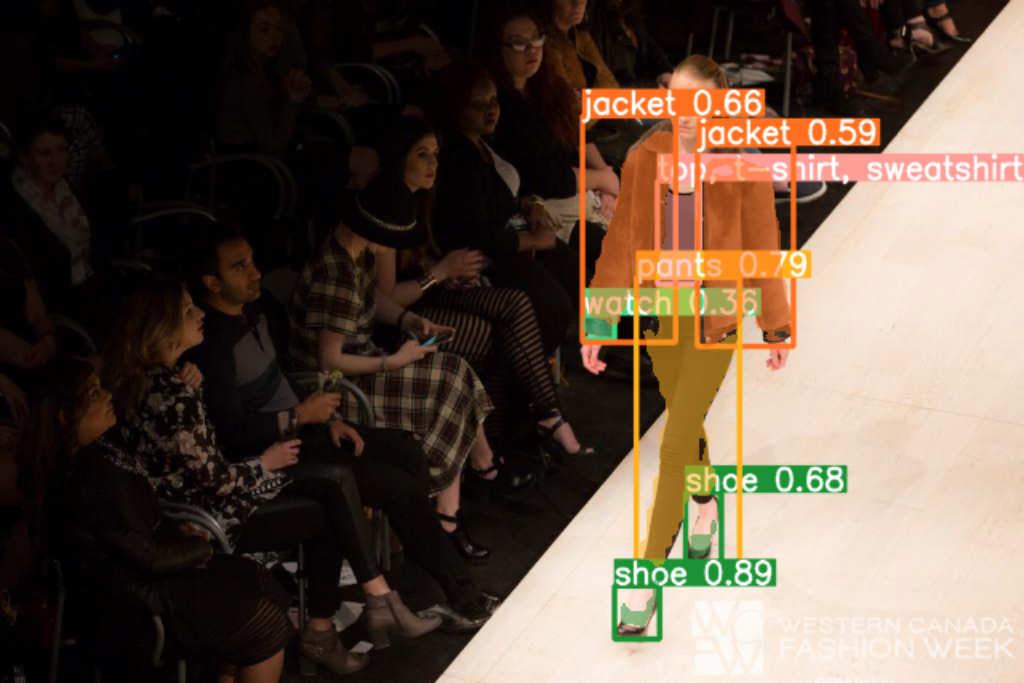

In [ ]:
from google.colab.patches import cv2_imshow

res = model.predict('/content/dataset/test/e6e27f124b9b48926ea89258538f2cef.jpg')
res_plotted = res[0].plot()
cv2_imshow(res_plotted)

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8s-seg.pt")

results = model.train(
        batch=12,
        device='0',
        data="dataset.yaml",
        epochs=14,
        imgsz=640,
        pretrained=True,
        visualize=True
    )

  0%|          | 0.00/22.8M [00:00<?, ?B/s]

Ultralytics YOLOv8.0.58 🚀 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=segment, mode=train, model=yolov8s-seg.pt, data=dataset.yaml, epochs=14, patience=50, batch=12, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=True, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=Fa

  0%|          | 0.00/755k [00:00<?, ?B/s]

Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.Conv                  [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.C2f                   [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.Conv                  [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.C2f                   [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

  0%|          | 0.00/6.23M [00:00<?, ?B/s]

AMP: checks passed ✅
optimizer: SGD(lr=0.01) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.00046875), 76 bias
train: Scanning /content/labels/train... 6646 images, 14 backgrounds, 0 corrupt: 100%|██████████| 6646/6646 [00:09<00:00, 673.99it/s]
train: WARNING ⚠️ /content/images/train/22710b0d510bc0032e92c13c93ca7d75.jpg: 1 duplicate labels removed
train: New cache created: /content/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
val: Scanning /content/labels/val... 1455 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1455/1455 [00:02<00:00, 677.87it/s]
val: New cache created: /content/labels/val.cache
Plotting labels to runs/segment/train/labels.jpg... 
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 14 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/runs_14_epoch /content/drive/MyDrive

In [ ]:
%cd /content/images/train

/content/images/train


In [ ]:
import os

_, _, files = next(os.walk("/content/images/train"))
file_count = len(files)

In [ ]:
file_count

9167

In [ ]:
!ls | wc -l

In [ ]:
import json
import pandas as pd

with open('/content/instances_attributes_train2020.json', encoding='utf-8') as cocojson:
        annotations_json = json.load(cocojson)

    # Store the 3 sections of the json as seperate json arrays
images = pd.json_normalize(annotations_json["annotations"])
images

In [ ]:
images['segmentation'].isna().sum()

In [ ]:
dataset.df.head(5)

In [ ]:
dataset.export.ExportToVoc(output_path='model_1/labels', segmented_=True)

In [ ]:
dataset.export.ExportToYoloV5(output_path='model_training/labels',yaml_file='dataset.yaml', copy_images=True, segmentation=True)

In [ ]:
dataset.path_to_annotations = "/content/dataset/yolo"
dataset.export.ExportToYoloV5()[0]

In [ ]:
e.ExportToYoloV5(output_path='test4_yolo', yaml_file="dataset.yaml",
        copy_images=False, segmentation=True, use_splits=True)

## extra code

In [ ]:
import pandas as pd 
import os
from sklearn.model_selection import train_test_split

PATH = '/content/dataset/train'
list_img=[img for img in os.listdir(PATH) if img.endswith('.jpg')==True]

path_img=[]

for i in range (len(list_img)):
    path_img.append(PATH+list_img[i])
    
df=pd.DataFrame(path_img)

# split 
data_train, data_test, labels_train, labels_test = train_test_split(df[0], df.index, test_size=0.20, random_state=42)

In [ ]:
import glob
import os
import shutil
from pathlib import Path

import numpy as np
from PIL import ExifTags
from tqdm import tqdm

# Parameters
img_formats = ['bmp', 'jpg', 'jpeg', 'png', 'tif', 'tiff', 'dng']  # acceptable image suffixes
vid_formats = ['mov', 'avi', 'mp4', 'mpg', 'mpeg', 'm4v', 'wmv', 'mkv']  # acceptable video suffixes

# Get orientation exif tag
for orientation in ExifTags.TAGS.keys():
    if ExifTags.TAGS[orientation] == 'Orientation':
        break


def exif_size(img):
    # Returns exif-corrected PIL size
    s = img.size  # (width, height)
    try:
        rotation = dict(img._getexif().items())[orientation]
        if rotation in [6, 8]:  # rotation 270
            s = (s[1], s[0])
    except:
        pass

    return s


def split_rows_simple(file='../data/sm4/out.txt'):  # from utils import *; split_rows_simple()
    # splits one textfile into 3 smaller ones based upon train, test, val ratios
    with open(file) as f:
        lines = f.readlines()

    s = Path(file).suffix
    lines = sorted(list(filter(lambda x: len(x) > 0, lines)))
    i, j, k = split_indices(lines, train=0.9, test=0.1, validate=0.0)
    for k, v in {'train': i, 'test': j, 'val': k}.items():  # key, value pairs
        if v.any():
            new_file = file.replace(s, f'_{k}{s}')
            with open(new_file, 'w') as f:
                f.writelines([lines[i] for i in v])


def split_files(out_path, file_name, prefix_path=''):  # split training data
    file_name = list(filter(lambda x: len(x) > 0, file_name))
    file_name = sorted(file_name)
    i, j, k = split_indices(file_name, train=0.9, test=0.1, validate=0.0)
    datasets = {'train': i, 'test': j, 'val': k}
    for key, item in datasets.items():
        if item.any():
            with open(f'{out_path}_{key}.txt', 'a') as file:
                for i in item:
                    file.write('%s%s\n' % (prefix_path, file_name[i]))


def split_indices(x, train=0.9, test=0.1, validate=0.0, shuffle=True):  # split training data
    n = len(x)
    v = np.arange(n)
    if shuffle:
        np.random.shuffle(v)

    i = round(n * train)  # train
    j = round(n * test) + i  # test
    k = round(n * validate) + j  # validate
    return v[:i], v[i:j], v[j:k]  # return indices


def make_dirs(dir='new_dir/'):
    # Create folders
    dir = Path(dir)
    if dir.exists():
        shutil.rmtree(dir)  # delete dir
    for p in dir, dir / 'labels', dir / 'images':
        p.mkdir(parents=True, exist_ok=True)  # make dir
    return dir


def write_data_data(fname='data.data', nc=80):
    # write darknet *.data file
    lines = ['classes = %g\n' % nc,
             'train =../out/data_train.txt\n',
             'valid =../out/data_test.txt\n',
             'names =../out/data.names\n',
             'backup = backup/\n',
             'eval = coco\n']

    with open(fname, 'a') as f:
        f.writelines(lines)


def image_folder2file(folder='images/'):  # from utils import *; image_folder2file()
    # write a txt file listing all imaged in folder
    s = glob.glob(f'{folder}*.*')
    with open(f'{folder[:-1]}.txt', 'w') as file:
        for l in s:
            file.write(l + '\n')  # write image list


def add_coco_background(path='../data/sm4/', n=1000):  # from utils import *; add_coco_background()
    # add coco background to sm4 in outb.txt
    p = f'{path}background'
    if os.path.exists(p):
        shutil.rmtree(p)  # delete output folder
    os.makedirs(p)  # make new output folder

    # copy images
    for image in glob.glob('../coco/images/train2014/*.*')[:n]:
        os.system(f'cp {image} {p}')

    # add to outb.txt and make train, test.txt files
    f = f'{path}out.txt'
    fb = f'{path}outb.txt'
    os.system(f'cp {f} {fb}')
    with open(fb, 'a') as file:
        file.writelines(i + '\n' for i in glob.glob(f'{p}/*.*'))
    split_rows_simple(file=fb)


def create_single_class_dataset(path='../data/sm3'):  # from utils import *; create_single_class_dataset('../data/sm3/')
    # creates a single-class version of an existing dataset
    os.system(f'mkdir {path}_1cls')


def flatten_recursive_folders(path='../../Downloads/data/sm4/'):  # from utils import *; flatten_recursive_folders()
    # flattens nested folders in path/images and path/JSON into single folders
    idir, jdir = f'{path}images/', f'{path}json/'
    nidir, njdir = Path(f'{path}images_flat/'), Path(f'{path}json_flat/')
    n = 0

    # Create output folders
    for p in [nidir, njdir]:
        if os.path.exists(p):
            shutil.rmtree(p)  # delete output folder
        os.makedirs(p)  # make new output folder

    for parent, dirs, files in os.walk(idir):
        for f in tqdm(files, desc=parent):
            f = Path(f)
            stem, suffix = f.stem, f.suffix
            if suffix.lower()[1:] in img_formats:
                n += 1
                stem_new = '%g_' % n + stem
                image_new = nidir / (stem_new + suffix)  # converts all formats to *.jpg
                json_new = njdir / f'{stem_new}.json'

                image = parent / f
                json = Path(parent.replace('images', 'json')) / str(f).replace(suffix, '.json')

                os.system("cp '%s' '%s'" % (json, json_new))
                os.system("cp '%s' '%s'" % (image, image_new))
                # cv2.imwrite(str(image_new), cv2.imread(str(image)))

    print('Flattening complete: %g jsons and images' % n)


def coco91_to_coco80_class():  # converts 80-index (val2014) to 91-index (paper)
    # https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
    x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, None, 24, 25, None,
         None, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, None, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
         51, 52, 53, 54, 55, 56, 57, 58, 59, None, 60, None, None, 61, None, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
         None, 73, 74, 75, 76, 77, 78, 79, None]
    return x

In [ ]:
import contextlib
import json

import cv2
import pandas as pd
from PIL import Image
from collections import defaultdict

# Convert INFOLKS JSON file into YOLO-format labels ----------------------------
def convert_infolks_json(name, files, img_path):
    # Create folders
    path = make_dirs()

    # Import json
    data = []
    for file in glob.glob(files):
        with open(file) as f:
            jdata = json.load(f)
            jdata['json_file'] = file
            data.append(jdata)

    # Write images and shapes
    name = path + os.sep + name
    file_id, file_name, wh, cat = [], [], [], []
    for x in tqdm(data, desc='Files and Shapes'):
        f = glob.glob(img_path + Path(x['json_file']).stem + '.*')[0]
        file_name.append(f)
        wh.append(exif_size(Image.open(f)))  # (width, height)
        cat.extend(a['classTitle'].lower() for a in x['output']['objects'])  # categories

        # filename
        with open(name + '.txt', 'a') as file:
            file.write('%s\n' % f)

    # Write *.names file
    names = sorted(np.unique(cat))
    # names.pop(names.index('Missing product'))  # remove
    with open(name + '.names', 'a') as file:
        [file.write('%s\n' % a) for a in names]

    # Write labels file
    for i, x in enumerate(tqdm(data, desc='Annotations')):
        label_name = Path(file_name[i]).stem + '.txt'

        with open(path + '/labels/' + label_name, 'a') as file:
            for a in x['output']['objects']:
                # if a['classTitle'] == 'Missing product':
                #    continue  # skip

                category_id = names.index(a['classTitle'].lower())

                # The INFOLKS bounding box format is [x-min, y-min, x-max, y-max]
                box = np.array(a['points']['exterior'], dtype=np.float32).ravel()
                box[[0, 2]] /= wh[i][0]  # normalize x by width
                box[[1, 3]] /= wh[i][1]  # normalize y by height
                box = [box[[0, 2]].mean(), box[[1, 3]].mean(), box[2] - box[0], box[3] - box[1]]  # xywh
                if (box[2] > 0.) and (box[3] > 0.):  # if w > 0 and h > 0
                    file.write('%g %.6f %.6f %.6f %.6f\n' % (category_id, *box))

    # Split data into train, test, and validate files
    split_files(name, file_name)
    write_data_data(name + '.data', nc=len(names))
    print(f'Done. Output saved to {os.getcwd() + os.sep + path}')


# Convert vott JSON file into YOLO-format labels -------------------------------
def convert_vott_json(name, files, img_path):
    # Create folders
    path = make_dirs()
    name = path + os.sep + name

    # Import json
    data = []
    for file in glob.glob(files):
        with open(file) as f:
            jdata = json.load(f)
            jdata['json_file'] = file
            data.append(jdata)

    # Get all categories
    file_name, wh, cat = [], [], []
    for i, x in enumerate(tqdm(data, desc='Files and Shapes')):
        with contextlib.suppress(Exception):
            cat.extend(a['tags'][0] for a in x['regions'])  # categories

    # Write *.names file
    names = sorted(pd.unique(cat))
    with open(name + '.names', 'a') as file:
        [file.write('%s\n' % a) for a in names]

    # Write labels file
    n1, n2 = 0, 0
    missing_images = []
    for i, x in enumerate(tqdm(data, desc='Annotations')):

        f = glob.glob(img_path + x['asset']['name'] + '.jpg')
        if len(f):
            f = f[0]
            file_name.append(f)
            wh = exif_size(Image.open(f))  # (width, height)

            n1 += 1
            if (len(f) > 0) and (wh[0] > 0) and (wh[1] > 0):
                n2 += 1

                # append filename to list
                with open(name + '.txt', 'a') as file:
                    file.write('%s\n' % f)

                # write labelsfile
                label_name = Path(f).stem + '.txt'
                with open(path + '/labels/' + label_name, 'a') as file:
                    for a in x['regions']:
                        category_id = names.index(a['tags'][0])

                        # The INFOLKS bounding box format is [x-min, y-min, x-max, y-max]
                        box = a['boundingBox']
                        box = np.array([box['left'], box['top'], box['width'], box['height']]).ravel()
                        box[[0, 2]] /= wh[0]  # normalize x by width
                        box[[1, 3]] /= wh[1]  # normalize y by height
                        box = [box[0] + box[2] / 2, box[1] + box[3] / 2, box[2], box[3]]  # xywh

                        if (box[2] > 0.) and (box[3] > 0.):  # if w > 0 and h > 0
                            file.write('%g %.6f %.6f %.6f %.6f\n' % (category_id, *box))
        else:
            missing_images.append(x['asset']['name'])

    print('Attempted %g json imports, found %g images, imported %g annotations successfully' % (i, n1, n2))
    if len(missing_images):
        print('WARNING, missing images:', missing_images)

    # Split data into train, test, and validate files
    split_files(name, file_name)
    print(f'Done. Output saved to {os.getcwd() + os.sep + path}')


# Convert ath JSON file into YOLO-format labels --------------------------------
def convert_ath_json(json_dir):  # dir contains json annotations and images
    # Create folders
    dir = make_dirs()  # output directory

    jsons = []
    for dirpath, dirnames, filenames in os.walk(json_dir):
        jsons.extend(
            os.path.join(dirpath, filename)
            for filename in [
                f for f in filenames if f.lower().endswith('.json')
            ]
        )

    # Import json
    n1, n2, n3 = 0, 0, 0
    missing_images, file_name = [], []
    for json_file in sorted(jsons):
        with open(json_file) as f:
            data = json.load(f)

        # # Get classes
        # try:
        #     classes = list(data['_via_attributes']['region']['class']['options'].values())  # classes
        # except:
        #     classes = list(data['_via_attributes']['region']['Class']['options'].values())  # classes

        # # Write *.names file
        # names = pd.unique(classes)  # preserves sort order
        # with open(dir + 'data.names', 'w') as f:
        #     [f.write('%s\n' % a) for a in names]

        # Write labels file
        for x in tqdm(data['_via_img_metadata'].values(), desc=f'Processing {json_file}'):
            image_file = str(Path(json_file).parent / x['filename'])
            f = glob.glob(image_file)  # image file
            if len(f):
                f = f[0]
                file_name.append(f)
                wh = exif_size(Image.open(f))  # (width, height)

                n1 += 1  # all images
                if len(f) > 0 and wh[0] > 0 and wh[1] > 0:
                    label_file = dir + 'labels/' + Path(f).stem + '.txt'

                    nlabels = 0
                    try:
                        with open(label_file, 'a') as file:  # write labelsfile
                            # try:
                            #     category_id = int(a['region_attributes']['class'])
                            # except:
                            #     category_id = int(a['region_attributes']['Class'])
                            category_id = 0  # single-class

                            for a in x['regions']:
                                # bounding box format is [x-min, y-min, x-max, y-max]
                                box = a['shape_attributes']
                                box = np.array([box['x'], box['y'], box['width'], box['height']],
                                               dtype=np.float32).ravel()
                                box[[0, 2]] /= wh[0]  # normalize x by width
                                box[[1, 3]] /= wh[1]  # normalize y by height
                                box = [box[0] + box[2] / 2, box[1] + box[3] / 2, box[2],
                                       box[3]]  # xywh (left-top to center x-y)

                                if box[2] > 0. and box[3] > 0.:  # if w > 0 and h > 0
                                    file.write('%g %.6f %.6f %.6f %.6f\n' % (category_id, *box))
                                    n3 += 1
                                    nlabels += 1

                        if nlabels == 0:  # remove non-labelled images from dataset
                            os.system(f'rm {label_file}')
                            # print('no labels for %s' % f)
                            continue  # next file

                        # write image
                        img_size = 4096  # resize to maximum
                        img = cv2.imread(f)  # BGR
                        assert img is not None, 'Image Not Found ' + f
                        r = img_size / max(img.shape)  # size ratio
                        if r < 1:  # downsize if necessary
                            h, w, _ = img.shape
                            img = cv2.resize(img, (int(w * r), int(h * r)), interpolation=cv2.INTER_AREA)

                        ifile = dir + 'images/' + Path(f).name
                        if cv2.imwrite(ifile, img):  # if success append image to list
                            with open(dir + 'data.txt', 'a') as file:
                                file.write('%s\n' % ifile)
                            n2 += 1  # correct images

                    except Exception:
                        os.system(f'rm {label_file}')
                        print(f'problem with {f}')

            else:
                missing_images.append(image_file)

    nm = len(missing_images)  # number missing
    print('\nFound %g JSONs with %g labels over %g images. Found %g images, labelled %g images successfully' %
          (len(jsons), n3, n1, n1 - nm, n2))
    if len(missing_images):
        print('WARNING, missing images:', missing_images)

    # Write *.names file
    names = ['knife']  # preserves sort order
    with open(dir + 'data.names', 'w') as f:
        [f.write('%s\n' % a) for a in names]

    # Split data into train, test, and validate files
    split_rows_simple(dir + 'data.txt')
    write_data_data(dir + 'data.data', nc=1)
    print(f'Done. Output saved to {Path(dir).absolute()}')


def convert_coco_json(json_dir='../coco/annotations/', use_segments=False, cls91to80=False):
    save_dir = make_dirs()  # output directory
    coco80 = coco91_to_coco80_class()

    # Import json
    for json_file in sorted(Path(json_dir).resolve().glob('*.json')):
        fn = Path(save_dir) / 'labels' / json_file.stem.replace('instances_', '')  # folder name
        fn.mkdir()
        with open(json_file) as f:
            data = json.load(f)

        # Create image dict
        images = {'%g' % x['id']: x for x in data['images']}
        # Create image-annotations dict
        imgToAnns = defaultdict(list)
        for ann in data['annotations']:
            imgToAnns[ann['image_id']].append(ann)

        # Write labels file
        for img_id, anns in tqdm(imgToAnns.items(), desc=f'Annotations {json_file}'):
            img = images['%g' % img_id]
            h, w, f = img['height'], img['width'], img['file_name']

            bboxes = []
            segments = []
            for ann in anns:
                if ann['iscrowd']:
                    continue
                # The COCO box format is [top left x, top left y, width, height]
                box = np.array(ann['bbox'], dtype=np.float64)
                box[:2] += box[2:] / 2  # xy top-left corner to center
                box[[0, 2]] /= w  # normalize x
                box[[1, 3]] /= h  # normalize y
                if box[2] <= 0 or box[3] <= 0:  # if w <= 0 and h <= 0
                    continue

                cls = coco80[ann['category_id'] - 1] if cls91to80 else ann['category_id'] - 1  # class
                box = [cls] + box.tolist()
                if box not in bboxes:
                    bboxes.append(box)
                # Segments
                if use_segments:
                    if len(ann['segmentation']) > 1:
                        s = merge_multi_segment(ann['segmentation'])
                        s = (np.concatenate(s, axis=0) / np.array([w, h])).reshape(-1).tolist()
                    else:
                        s = [j for i in ann['segmentation'] for j in i]  # all segments concatenated
                        s = (np.array(s).reshape(-1, 2) / np.array([w, h])).reshape(-1).tolist()
                    s = [cls] + s
                    if s not in segments:
                        segments.append(s)

            # Write
            with open((fn / f).with_suffix('.txt'), 'a') as file:
                for i in range(len(bboxes)):
                    line = *(segments[i] if use_segments else bboxes[i]),  # cls, box or segments
                    file.write(('%g ' * len(line)).rstrip() % line + '\n')


def min_index(arr1, arr2):
    """Find a pair of indexes with the shortest distance. 
    Args:
        arr1: (N, 2).
        arr2: (M, 2).
    Return:
        a pair of indexes(tuple).
    """
    print((arr1[:, None, :] - arr2[None, :, :]))
    dis = ((arr1[:, None, :] - arr2[None, :, :]) ** 2).sum(-1)
    return np.unravel_index(np.argmin(dis, axis=None), dis.shape)


def merge_multi_segment(segments):
    """Merge multi segments to one list.
    Find the coordinates with min distance between each segment,
    then connect these coordinates with one thin line to merge all 
    segments into one.
    Args:
        segments(List(List)): original segmentations in coco's json file.
            like [segmentation1, segmentation2,...], 
            each segmentation is a list of coordinates.
    """
    s = []
    segments = [np.array(i).reshape(-1, 2) if len(np.array(i).shape) > 1 else i for i in segments]
    idx_list = [[] for _ in range(len(segments))]

    # record the indexes with min distance between each segment
    for i in range(1, len(segments)):
        idx1, idx2 = min_index(segments[i - 1], segments[i])
        idx_list[i - 1].append(idx1)
        idx_list[i].append(idx2)

    # use two round to connect all the segments
    for k in range(2):
        # forward connection
        if k == 0:
            for i, idx in enumerate(idx_list):
                # middle segments have two indexes
                # reverse the index of middle segments
                if len(idx) == 2 and idx[0] > idx[1]:
                    idx = idx[::-1]
                    segments[i] = segments[i][::-1, :]

                segments[i] = np.roll(segments[i], -idx[0], axis=0)
                segments[i] = np.concatenate([segments[i], segments[i][:1]])
                # deal with the first segment and the last one
                if i in [0, len(idx_list) - 1]:
                    s.append(segments[i])
                else:
                    idx = [0, idx[1] - idx[0]]
                    s.append(segments[i][idx[0]:idx[1] + 1])

        else:
            for i in range(len(idx_list) - 1, -1, -1):
                if i not in [0, len(idx_list) - 1]:
                    idx = idx_list[i]
                    nidx = abs(idx[1] - idx[0])
                    s.append(segments[i][nidx:])
    return s


def delete_dsstore(path='../datasets'):
    # Delete apple .DS_store files
    from pathlib import Path
    files = list(Path(path).rglob('.DS_store'))
    print(files)
    for f in files:
        f.unlink()


if __name__ == '__main__':
    source = 'COCO'

    if source == 'COCO':
        convert_coco_json('../datasets/coco/annotations',  # directory with *.json
                          use_segments=True,
                          cls91to80=True)

    elif source == 'infolks':  # Infolks https://infolks.info/
        convert_infolks_json(name='out',
                             files='../data/sm4/json/*.json',
                             img_path='../data/sm4/images/')

    elif source == 'vott':  # VoTT https://github.com/microsoft/VoTT
        convert_vott_json(name='data',
                          files='../../Downloads/athena_day/20190715/*.json',
                          img_path='../../Downloads/athena_day/20190715/')  # images folder

    elif source == 'ath':  # ath format
        convert_ath_json(json_dir='../../Downloads/athena/')  # images folder


In [ ]:
i = np.array([[1, 2, 3, 4], [1 ,3], [2, 4], [3], [4 , 5, 7]])
print(np.array(i).reshape(-1, 2))

In [ ]:
convert_coco_json('/content/', use_segments=True)

## COCO to VOC

In [ ]:
!git clone https://github.com/alicranck/coco2voc.git

Cloning into 'coco2voc'...
remote: Enumerating objects: 79, done.
remote: Total 79 (delta 0), reused 0 (delta 0), pack-reused 79
Unpacking objects: 100% (79/79), 30.33 KiB | 369.00 KiB/s, done.


In [ ]:
!pwd

/content


In [ ]:
%cd 

In [ ]:
schema = [
    "img_folder",
    "img_filename",
    "img_path",
    "img_id",
    "img_width",
    "img_height",
    "img_depth",
    "ann_segmented",
    "ann_bbox_xmin",
    "ann_bbox_ymin",
    "ann_bbox_xmax",
    "ann_bbox_ymax",
    "ann_bbox_width",
    "ann_bbox_height",
    "ann_area",
    "ann_segmentation",
    "ann_iscrowd",
    "ann_pose",
    "ann_truncated",
    "ann_difficult",
    "cat_id",
    "cat_name",
    "cat_supercategory",
    "split",
    "annotated",
]

In [ ]:

import json
import pandas as pd
import xml.etree.ElementTree as ET
import os
from os.path import exists
from pathlib import Path, PurePath
import copy
import cv2
import yaml
from tqdm import tqdm



def _GetValueOrBlank(element, user_input=None):
    """
    If an element is missing from the XML file reading the .text value will return an error.
    If the element does not exist return ""
    """
    if user_input == None:
        try:
            return element.text
        except AttributeError:
            return ""
    else:
        return user_input


# These are the valid columns in the pylabel annotations table.
def ImportCoco(path, path_to_images=None, name=None, encoding='utf-8'):
    """
    This function takes the path to a JSON file in COCO format as input. It returns a PyLabel dataset object that contains the annotations.
    Returns:
        PyLabel dataset object.
    Args:
        path (str):The path to the JSON file with the COCO annotations.
        path_to_images (str): The path to the images relative to the json file.
            If the images are in the same directory as the JSON file then omit this parameter.
            If the images are in a different directory on the same level as the annotations then you would
            set `path_to_images='../images/'`
        name (str): This will set the dataset.name property for this dataset.
            If not specified, the filename (without extension) of the COCO annotation file file will be used as the dataset name.
        encoding (str): Default is 'utf-8. Encoding of the annotations file(s).
    Example:
        >>> from pylabel import importer
        >>> dataset = importer.ImportCoco("coco_annotations.json")
    """
    with open(path, encoding=encoding) as cocojson:
        annotations_json = json.load(cocojson)

    # Store the 3 sections of the json as seperate json arrays
    images = pd.json_normalize(annotations_json["images"])
    images.columns = "img_" + images.columns
    try:
        images["img_folder"]
    except:
        images["img_folder"] = ""
    # print(images)

    # If the user has specified a different image folder then use that one
    if path_to_images != None:
        images["img_folder"] = path_to_images

    astype_dict = {"img_width": "int64", "img_height": "int64", "img_depth": "int64"}
    astype_keys = list(astype_dict.keys())
    for element in astype_keys:
        if element not in images.columns:
            astype_dict.pop(element)
    # print(astype_dict)
    # images = images.astype({'img_width': 'int64','img_height': 'int64','img_depth': 'int64'})
    images = images.astype(astype_dict)

    annotations = pd.json_normalize(annotations_json["annotations"])
    annotations.columns = "ann_" + annotations.columns

    categories = pd.json_normalize(annotations_json["categories"])
    categories.columns = "cat_" + categories.columns

    # Converting this to string resolves issue #23
    categories.cat_id = categories.cat_id.astype(str)

    df = annotations

    # Converting this to string resolves issue #23
    df.ann_category_id = df.ann_category_id.astype(str)

    df[
        ["ann_bbox_xmin", "ann_bbox_ymin", "ann_bbox_width", "ann_bbox_height"]
    ] = pd.DataFrame(df.ann_bbox.tolist(), index=df.index)
    df.insert(8, "ann_bbox_xmax", df["ann_bbox_xmin"] + df["ann_bbox_width"])
    df.insert(10, "ann_bbox_ymax", df["ann_bbox_ymin"] + df["ann_bbox_height"])

    # debug print(df.info())

    # Join the annotions with the information about the image to add the image columns to the dataframe
    df = pd.merge(images, df, left_on="img_id", right_on="ann_image_id", how="left")
    df = pd.merge(
        df, categories, left_on="ann_category_id", right_on="cat_id", how="left"
    )

    # Rename columns if needed from the coco column name to the pylabel column name
    df.rename(columns={"img_file_name": "img_filename"}, inplace=True)

    # Drop columns that are not in the schema
    df = df[df.columns.intersection(schema)]

    # Add missing columns that are in the schema but not part of the table
    df[list(set(schema) - set(df.columns))] = ""

    # Reorder columns
    df = df[schema]
    df.index.name = "id"
    df.annotated = 1

    # Fill na values with empty strings which resolved some errors when
    # working with images that don't have any annotations
    df = df[df['ann_segmentation'].notna()]
    df.fillna("", inplace=True)

    # These should be strings
    df.cat_id = df.cat_id.astype(str)

    # These should be integers
    df.img_width = df.img_width.astype(int)
    df.img_height = df.img_height.astype(int)


    return df

In [ ]:
import json
from typing import List
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import xml.dom.minidom
import os
import yaml
import shutil
from pylabel.shared import _ReindexCatIds
from tqdm import tqdm
import csv

from pathlib import PurePath, Path


class Export:
    def __init__(self, dataset=None):
        self.dataset = dataset
    
    def ExportToYoloV5(
        self,
        output_path="training/labels",
        yaml_file="dataset.yaml",
        copy_images=False,
        use_splits=False,
        cat_id_index=None,
        segmentation=False,
    ):
        """Writes annotation files to disk in YOLOv5 format and returns the paths to files.
        Args:
            output_path (str):
                This is where the annotation files will be written.
                If not-specified then the path will be derived from the .path_to_annotations and
                .name properties of the dataset object. If you are exporting images to train a model, the recommended path
                to use is 'training/labels'.
            yaml_file (str):
                If a file name (string) is provided, a YOLOv5 YAML file will be created with entries for the files
                and classes in this dataset. It will be created in the parent of the output_path directory.
                The recommended name for the YAML file is 'dataset.yaml'.
            copy_images (boolean):
                If True, then the annotated images will be copied to a directory next to the labels directory into
                a directory named 'images'. This will prepare your labels and images to be used as inputs to
                train a YOLOv5 model.
            use_splits (boolean):
                If True, then the images and annotations will be moved into directories based on the values in the split column.
                For example, if a row has the value split = "train" then the annotations for that row will be moved to directory
                /train. If a YAML file is specificied then the YAML file will use the splits to specify the folders user for the
                train, val, and test datasets.
            cat_id_index (int):
                Reindex the cat_id values so that that they start from an int (usually 0 or 1) and
                then increment the cat_ids to index + number of categories continuously.
                It's useful if the cat_ids are not continuous in the original dataset.
                Yolo requires the set of annotations to start at 0 when training a model.
            segmentation (boolean):
                If true, then segmentation annotations will be exported instead of bounding box annotations.
                If there are no segmentation annotations, then no annotations will be empty.
        Returns:
            A list with 1 or more paths (strings) to annotations files. If a YAML file is created
            then the first item in the list will be the path to the YAML file.
        Examples:
            >>> dataset.export.ExportToYoloV5(output_path='training/labels',
            >>>     yaml_file='dataset.yaml', cat_id_index=0)
            ['training/dataset.yaml', 'training/labels/frame_0002.txt', ...]
        """
        ds = self.dataset

        # Inspired by https://github.com/aws-samples/groundtruth-object-detection/blob/master/create_annot.py
        yolo_dataset = ds.df.copy(deep=True)
        # Convert nan values in the split column from nan to '' because those are easier to work with with when building paths
        yolo_dataset.split = yolo_dataset.split.fillna("")

        # Create all of the paths that will be used to manage the files in this dataset
        path_dict = {}

        # The output path is the main path that will be used to create the other relative paths
        path = PurePath(output_path)
        path_dict["label_path"] = output_path
        # The /images directory should be next to the /labels directory
        path_dict["image_path"] = str(PurePath(path.parent, "images"))
        # The root directory is in parent of the /labels and /images directories
        path_dict["root_path"] = str(PurePath(path.parent))
        # The YAML file should be in root directory
        path_dict["yaml_path"] = str(PurePath(path_dict["root_path"], yaml_file))
        # The root directory will usually be next to the yolov5 directory.
        # Specify the relative path
        path_dict["root_path_from_yolo_dir"] = str(PurePath("../"))
        # If these default values to not match the users environment then they can manually edit the YAML file

        if copy_images:
            # Create the folder that the images will be copied to
            Path(path_dict["image_path"]).mkdir(parents=True, exist_ok=True)

        # Drop rows that are not annotated
        # Note, having zero annotates can still be considered annotated
        # in cases when are no objects in the image thats should be indentified
        yolo_dataset = yolo_dataset.loc[yolo_dataset["annotated"] == 1]
        yolo_dataset = yolo_dataset.loc[yolo_dataset["ann_segmentation"] != ""]

        # yolo_dataset["cat_id"] = (
        #     yolo_dataset["cat_id"].astype("float").astype(pd.Int32Dtype())
        # )

        yolo_dataset.cat_id = yolo_dataset.cat_id.replace(r"^\s*$", np.nan, regex=True)

        pd.to_numeric(yolo_dataset["cat_id"])

        if cat_id_index != None:
            assert isinstance(cat_id_index, int), "cat_id_index must be an int."
            _ReindexCatIds(yolo_dataset, cat_id_index)

        # Convert empty bbox coordinates to nan to avoid math errors
        # If an image has no annotations then an empty label file will be created
        yolo_dataset.ann_bbox_xmin = yolo_dataset.ann_bbox_xmin.replace(
            r"^\s*$", np.nan, regex=True
        )
        yolo_dataset.ann_bbox_ymin = yolo_dataset.ann_bbox_ymin.replace(
            r"^\s*$", np.nan, regex=True
        )
        yolo_dataset.ann_bbox_width = yolo_dataset.ann_bbox_width.replace(
            r"^\s*$", np.nan, regex=True
        )
        yolo_dataset.ann_bbox_height = yolo_dataset.ann_bbox_height.replace(
            r"^\s*$", np.nan, regex=True
        )

        # If segmentation = False then export bounding boxes
        if segmentation == False:

            yolo_dataset["center_x_scaled"] = (
                yolo_dataset["ann_bbox_xmin"] + (yolo_dataset["ann_bbox_width"] * 0.5)
            ) / yolo_dataset["img_width"]
            yolo_dataset["center_y_scaled"] = (
                yolo_dataset["ann_bbox_ymin"] + (yolo_dataset["ann_bbox_height"] * 0.5)
            ) / yolo_dataset["img_height"]
            yolo_dataset["width_scaled"] = (
                yolo_dataset["ann_bbox_width"] / yolo_dataset["img_width"]
            )
            yolo_dataset["height_scaled"] = (
                yolo_dataset["ann_bbox_height"] / yolo_dataset["img_height"]
            )

        # Create folders to store annotations
        if output_path == None:
            dest_folder = PurePath(
                ds.path_to_annotations, yolo_dataset.iloc[0].img_folder
            )
        else:
            dest_folder = output_path

        os.makedirs(dest_folder, exist_ok=True)

        unique_images = yolo_dataset["img_filename"].unique()
        output_file_paths = []
        pbar = tqdm(desc="Exporting YOLO files...", total=len(unique_images))
        for img_filename in unique_images:
            df_single_img_annots = yolo_dataset.loc[
                yolo_dataset.img_filename == img_filename
            ]

            basename, _ = os.path.splitext(img_filename)
            annot_txt_file = basename + ".txt"
            # Use the value of the split collumn to create a directory
            # The values should be train, val, test or ''
            if use_splits:
                split_dir = df_single_img_annots.iloc[0].split
            else:
                split_dir = ""
            destination = str(PurePath(dest_folder, split_dir, annot_txt_file))
            Path(
                dest_folder,
                split_dir,
            ).mkdir(parents=True, exist_ok=True)

            # If segmentation = false then output bounding boxes
            if segmentation == False:

                df_single_img_annots.to_csv(
                    destination,
                    index=False,
                    header=False,
                    sep=" ",
                    float_format="%.4f",
                    columns=[
                        "cat_id",
                        "center_x_scaled",
                        "center_y_scaled",
                        "width_scaled",
                        "height_scaled",
                    ],
                )

            # If segmentation = true then output the segmentation mask
            else:
                # Create one file for image
                with open(destination, "w") as file:
                    # Create one row per row in the data frame
                    for i in range(0, df_single_img_annots.shape[0]):
                        row = df_single_img_annots.iloc[i].cat_id
                        segmentation_array = df_single_img_annots.iloc[
                            i
                        ].ann_segmentation[0]

                        # Iterate through every value of the segmentation array
                        # To normalize the coordinates from 0-1
                        for index, l in enumerate(segmentation_array):
                            # The first number in the array is the x value so divide by the width
                            if index % 2 == 0:
                                row += " " + (
                                    str(
                                        segmentation_array[index]
                                        / df_single_img_annots.iloc[i].img_width
                                    )
                                )
                            else:
                                # The first number in the array is the x value so divide by the height
                                row += " " + (
                                    str(
                                        segmentation_array[index]
                                        / df_single_img_annots.iloc[i].img_height
                                    )
                                )

                        file.write(row + "\n")

            output_file_paths.append(destination)

            if copy_images:
                source_image_path = str(
                    Path(
                        ds.path_to_annotations,
                        df_single_img_annots.iloc[0].img_folder,
                        df_single_img_annots.iloc[0].img_filename,
                    )
                )

                current_file = Path(source_image_path)
                assert (
                    current_file.is_file
                ), f"File does not exist: {source_image_path}. Check img_folder column values."
                Path(path_dict["image_path"], split_dir).mkdir(
                    parents=True, exist_ok=True
                )
                shutil.copy(
                    str(source_image_path),
                    str(PurePath(path_dict["image_path"], split_dir, img_filename)),
                )
            pbar.update()

        # Create YAML file
        if yaml_file:
            # Make a set with all of the different values of the split column
            splits = set(yolo_dataset.split)
            # Build a dict with all of the values that will go into the YAML file
            dict_file = {}
            dict_file["path"] = path_dict["root_path_from_yolo_dir"]

            # If train is one of the splits, append train to path
            if use_splits and "train" in splits:
                dict_file["train"] = str(PurePath(path_dict["image_path"], "train"))
            else:
                dict_file["train"] = path_dict["image_path"]

            # If val is one of the splits, append val to path
            if use_splits and "val" in splits:
                dict_file["val"] = str(PurePath(path_dict["image_path"], "val"))
            else:
                # If there is no val split, use the train split as the val split
                dict_file["val"] = dict_file["train"]

            # If test is one of the splits, make a test param and add test to the path
            if use_splits and "test" in splits:
                dict_file["test"] = str(PurePath(path_dict["image_path"], "test"))

            dict_file["nc"] = ds.analyze.num_classes
            dict_file["names"] = ds.analyze.classes

            # Save the yamlfile
            with open(path_dict["yaml_path"], "w") as file:
                documents = yaml.dump(dict_file, file)
                output_file_paths = [path_dict["yaml_path"]] + output_file_paths

        return output_file_paths


    def ExportToVoc(
        self,
        output_path=None,
        segmented_=False,
        path_=False,
        database_=False,
        folder_=False,
        occluded_=False,
    ):
        """Writes annotation files to disk in VOC XML format and returns path to files.
        By default, tags with empty values will not be included in the XML output.
        You can optionally choose to include them if they are required for your solution.
        Args:
            output_path (str):
                This is where the annotation files will be written.
                If not-specified then the path will be derived from the .path_to_annotations and
                .name properties of the dataset object.
            segmented_ (bool) :
                Defaults to False. Set to true to include this field in the XML schema of the output files.
            path_ (bool) :
                Defaults to False. Set to true to include this field in the XML schema of the output files.
            database_ (bool) :
                Defaults to False. Set to true to include this field in the XML schema of the output files.
            folder_ (bool) :
                Defaults to False. Set to true to include this field in the XML schema of the output files.
            occluded_ (bool) :
                Defaults to False. Set to true to include this field in the XML schema of the output files.
        Returns:
            A list with 1 or more paths (strings) to annotations files.
        Example:
            >>> dataset.export.ExportToVoc()
            ['data/voc_annotations/000000000322.xml', ...]
        """
        ds = self.dataset

        if output_path == None:
            output_path = ds.path_to_annotations
        else:
            output_path = output_path

        os.makedirs(output_path, exist_ok=True)

        output_file_paths = []

        def voc_xml_file_creation(
            data,
            file_name,
            output_file_path,
            segmented=True,
            path=True,
            database=True,
            folder=True,
            occluded=True,
        ):

            index = 0
            df_smaller = data[data["img_filename"] == file_name].reset_index()

            if len(df_smaller) == 1:
                # print('test')
                annotation_text_start = "<annotation>"

                flder_lkp = str(df_smaller.loc[index]["img_folder"])
                if folder == True and flder_lkp != "":
                    folder_text = "<folder>" + flder_lkp + "</folder>"
                else:
                    folder_text = ""

                filename_text = (
                    "<filename>"
                    + str(df_smaller.loc[index]["img_filename"])
                    + "</filename>"
                )

                pth_lkp = str(df_smaller.loc[index]["img_path"])
                if path == True and pth_lkp != "":
                    path_text = "<path>" + pth_lkp + "</path>"
                else:
                    path_text = ""

                sources_text = ""

                size_text_start = "<size>"
                width_text = (
                    "<width>" + str(df_smaller.loc[index]["img_width"]) + "</width>"
                )
                height_text = (
                    "<height>" + str(df_smaller.loc[index]["img_height"]) + "</height>"
                )
                depth_text = (
                    "<depth>" + str(df_smaller.loc[index]["img_depth"]) + "</depth>"
                )
                size_text_end = "</size>"

                seg_lkp = str(df_smaller.loc[index]["ann_segmentation"])
                if segmented == True and seg_lkp != "":
                    segmented_text = (
                        "<segmented>"
                        + str(df_smaller.loc[index]["ann_segmentation"])
                        + "</segmented>"
                    )
                else:
                    segmented_text = ""

                # If the image has no annotations, skip this part of the output
                no_annotations = (
                    pd.isnull(df_smaller.loc[index]["cat_id"])
                    or df_smaller.loc[index]["cat_id"] == ""
                )

                if not no_annotations:
                    object_text_start = "<object>"

                    name_text = (
                        "<name>" + str(df_smaller.loc[index]["cat_name"]) + "</name>"
                    )
                    pose_text = (
                        "<pose>" + str(df_smaller.loc[index]["ann_pose"]) + "</pose>"
                    )
                    truncated_text = (
                        "<truncated>"
                        + str(df_smaller.loc[index]["ann_truncated"])
                        + "</truncated>"
                    )
                    difficult_text = (
                        "<difficult>"
                        + str(df_smaller.loc[index]["ann_difficult"])
                        + "</difficult>"
                    )

                    occluded_text = ""

                    bound_box_text_start = "<bndbox>"

                    xmin_text = (
                        "<xmin>"
                        + str(int(df_smaller.loc[index]["ann_bbox_xmin"]))
                        + "</xmin>"
                    )
                    xmax_text = (
                        "<xmax>"
                        + str(int(df_smaller.loc[index]["ann_bbox_xmax"]))
                        + "</xmax>"
                    )
                    ymin_text = (
                        "<ymin>"
                        + str(int(df_smaller.loc[index]["ann_bbox_ymin"]))
                        + "</ymin>"
                    )
                    ymax_text = (
                        "<ymax>"
                        + str(int(df_smaller.loc[index]["ann_bbox_ymax"]))
                        + "</ymax>"
                    )

                    bound_box_text_end = "</bndbox>"
                    object_text_end = "</object>"
                else:
                    object_text_start = ""
                    name_text = ""
                    pose_text = ""
                    truncated_text = ""
                    difficult_text = ""
                    occluded_text = ""
                    bound_box_text_start = ""
                    xmin_text = ""
                    xmax_text = ""
                    ymin_text = ""
                    ymax_text = ""
                    bound_box_text_end = ""
                    object_text_end = ""

                # Continue this part even if there are no annotations for this image
                annotation_text_end = "</annotation>"

                xmlstring = (
                    annotation_text_start
                    + folder_text
                    + filename_text
                    + path_text
                    + sources_text
                    + size_text_start
                    + width_text
                    + height_text
                    + depth_text
                    + size_text_end
                    + segmented_text
                    + object_text_start
                    + name_text
                    + pose_text
                    + truncated_text
                    + difficult_text
                    + occluded_text
                    + bound_box_text_start
                    + xmin_text
                    + xmax_text
                    + ymin_text
                    + ymax_text
                    + bound_box_text_end
                    + object_text_end
                    + annotation_text_end
                )
                dom = xml.dom.minidom.parseString(xmlstring)
                pretty_xml_as_string = dom.toprettyxml()

                with open(output_file_path, "w") as f:
                    f.write(pretty_xml_as_string)

                return output_file_path

            else:
                # When there are more than one annotations for the image

                # print('test')
                annotation_text_start = "<annotation>"

                flder_lkp = str(df_smaller.loc[index]["img_folder"])
                if folder == True and flder_lkp != "":
                    folder_text = "<folder>" + flder_lkp + "</folder>"
                else:
                    folder_text = ""

                filename_text = (
                    "<filename>"
                    + str(df_smaller.loc[index]["img_filename"])
                    + "</filename>"
                )

                pth_lkp = str(df_smaller.loc[index]["img_path"])
                if path == True and pth_lkp != "":
                    path_text = "<path>" + pth_lkp + "</path>"
                else:
                    path_text = ""

                # db_lkp = str(df_smaller.loc[index]['Databases'])
                # if database == True and db_lkp != '':
                #    sources_text = '<source>'+'<database>'+ db_lkp +'</database>'+'</source>'
                # else:
                sources_text = ""

                size_text_start = "<size>"
                width_text = (
                    "<width>" + str(df_smaller.loc[index]["img_width"]) + "</width>"
                )
                height_text = (
                    "<height>" + str(df_smaller.loc[index]["img_height"]) + "</height>"
                )
                depth_text = (
                    "<depth>" + str(df_smaller.loc[index]["img_depth"]) + "</depth>"
                )
                size_text_end = "</size>"

                seg_lkp = str(df_smaller.loc[index]["ann_segmentation"])
                if segmented == True and seg_lkp != "":
                    segmented_text = (
                        "<segmented>"
                        + str(df_smaller.loc[index]["ann_segmentation"])
                        + "</segmented>"
                    )
                else:
                    segmented_text = ""

                xmlstring = (
                    annotation_text_start
                    + folder_text
                    + filename_text
                    + path_text
                    + sources_text
                    + size_text_start
                    + width_text
                    + height_text
                    + depth_text
                    + size_text_end
                    + segmented_text
                )

                for obj in range(len(df_smaller)):
                    object_text_start = "<object>"

                    name_text = (
                        "<name>" + str(df_smaller.loc[obj]["cat_name"]) + "</name>"
                    )
                    pose_text = (
                        "<pose>" + str(df_smaller.loc[obj]["ann_pose"]) + "</pose>"
                    )
                    truncated_text = (
                        "<truncated>"
                        + str(df_smaller.loc[obj]["ann_truncated"])
                        + "</truncated>"
                    )
                    difficult_text = (
                        "<difficult>"
                        + str(df_smaller.loc[obj]["ann_difficult"])
                        + "</difficult>"
                    )

                    # occ_lkp = str(df_smaller.loc[index]['Object Occluded'])
                    # if occluded==True and occ_lkp != '':
                    #    occluded_text = '<occluded>'+occ_lkp+'</occluded>'
                    # else:
                    occluded_text = ""

                    bound_box_text_start = "<bndbox>"

                    xmin_text = (
                        "<xmin>"
                        + str(int(df_smaller.loc[obj]["ann_bbox_xmin"]))
                        + "</xmin>"
                    )
                    xmax_text = (
                        "<xmax>"
                        + str(int(df_smaller.loc[obj]["ann_bbox_xmax"]))
                        + "</xmax>"
                    )
                    ymin_text = (
                        "<ymin>"
                        + str(int(df_smaller.loc[obj]["ann_bbox_ymin"]))
                        + "</ymin>"
                    )
                    ymax_text = (
                        "<ymax>"
                        + str(int(df_smaller.loc[obj]["ann_bbox_ymax"]))
                        + "</ymax>"
                    )

                    bound_box_text_end = "</bndbox>"
                    object_text_end = "</object>"
                    annotation_text_end = "</annotation>"
                    index = index + 1

                    xmlstring = (
                        xmlstring
                        + object_text_start
                        + name_text
                        + pose_text
                        + truncated_text
                        + difficult_text
                        + occluded_text
                        + bound_box_text_start
                        + xmin_text
                        + xmax_text
                        + ymin_text
                        + ymax_text
                        + bound_box_text_end
                        + object_text_end
                    )

                xmlstring = xmlstring + annotation_text_end
                dom = xml.dom.minidom.parseString(xmlstring)
                pretty_xml_as_string = dom.toprettyxml()

                with open(output_file_path, "w") as f:
                    f.write(pretty_xml_as_string)

                return output_file_path

        # Loop through all images in the dataframe and call voc_xml_file_creation for each one
        pbar = tqdm(desc="Exporting VOC files...", total=len(list(set(self.dataset.df.img_filename))))
        for file_title in list(set(self.dataset.df.img_filename)):
            file_name = Path(file_title)
            file_name = str(file_name.with_suffix(".xml"))
            file_path = str(Path(output_path, file_name))
            voc_file_path = voc_xml_file_creation(
                ds.df,
                file_title,
                segmented=segmented_,
                path=path_,
                database=database_,
                folder=folder_,
                occluded=occluded_,
                output_file_path=file_path,
            )
            output_file_paths.append(voc_file_path)
            pbar.update()

        return output_file_paths



In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit as sklearnGroupShuffleSplit

 
def GroupShuffleSplit(dataset, train_pct=.5, test_pct=.25, val_pct=.25, group_col = 'img_filename', random_state=None):
        """
        This function uses the GroupShuffleSplit command from sklearn. It can split into 3 groups (train,
        test, and val) by applying the command twice. 
        """
        df_main = dataset.df
        gss = sklearnGroupShuffleSplit(n_splits=1, train_size=train_pct)
        train_indexes, test_indexes = next(gss.split(X=df_main, y=df_main[group_col], groups=df_main.index.values))

        df_main.loc[train_indexes,'split'] = "train"
        df_main.loc[test_indexes,'split'] = "test"
        dataset.df = df_main

        if val_pct:
            df_train = df_main.loc[df_main['split'] == 'train']
            df_test = df_main.loc[df_main['split'] == 'test']
            df_test = df_test.reset_index()
            second_split_pct = float(test_pct/(test_pct+val_pct))
            gss2 = sklearnGroupShuffleSplit(n_splits=1, train_size=second_split_pct)
            test_indexes_2, val_indexes_2 = next(gss2.split(X=df_test, y=df_test[group_col], groups=df_test.index.values))
            df_test.loc[test_indexes_2,'split'] = "test"
            df_test.loc[val_indexes_2,'split'] = "val"
            dataset.df = df_train.append(df_test)
        dataset.df = dataset.df.reset_index(drop=True)
        dataset.df = dataset.df[schema]

In [ ]:
dataset.df

In [ ]:
path_to_annotations = "/content/instances_attributes_train2020.json"
#Specify the path to the images (if they are in a different folder than the annotations)
path_to_images = "/content/dataset/train/"

#Import the dataset into the pylable schema 
dataset = ImportCoco(path_to_annotations, path_to_images=path_to_images)

In [ ]:
dataset

In [ ]:
dataset.df[dataset.df['img_id'] == 17264]['ann_segmentation']

In [ ]:
e = Export(dataset)

## COCO to YOLO

In [ ]:
import glob
import os
import shutil
from pathlib import Path

import numpy as np
from PIL import ExifTags
from tqdm import tqdm

# Parameters
img_formats = ['bmp', 'jpg', 'jpeg', 'png', 'tif', 'tiff', 'dng']  # acceptable image suffixes
vid_formats = ['mov', 'avi', 'mp4', 'mpg', 'mpeg', 'm4v', 'wmv', 'mkv']  # acceptable video suffixes

# Get orientation exif tag
for orientation in ExifTags.TAGS.keys():
    if ExifTags.TAGS[orientation] == 'Orientation':
        break


def exif_size(img):
    # Returns exif-corrected PIL size
    s = img.size  # (width, height)
    try:
        rotation = dict(img._getexif().items())[orientation]
        if rotation in [6, 8]:  # rotation 270
            s = (s[1], s[0])
    except:
        pass

    return s


def split_rows_simple(file='../data/sm4/out.txt'):  # from utils import *; split_rows_simple()
    # splits one textfile into 3 smaller ones based upon train, test, val ratios
    with open(file) as f:
        lines = f.readlines()

    s = Path(file).suffix
    lines = sorted(list(filter(lambda x: len(x) > 0, lines)))
    i, j, k = split_indices(lines, train=0.9, test=0.1, validate=0.0)
    for k, v in {'train': i, 'test': j, 'val': k}.items():  # key, value pairs
        if v.any():
            new_file = file.replace(s, f'_{k}{s}')
            with open(new_file, 'w') as f:
                f.writelines([lines[i] for i in v])


def split_files(out_path, file_name, prefix_path=''):  # split training data
    file_name = list(filter(lambda x: len(x) > 0, file_name))
    file_name = sorted(file_name)
    i, j, k = split_indices(file_name, train=0.9, test=0.1, validate=0.0)
    datasets = {'train': i, 'test': j, 'val': k}
    for key, item in datasets.items():
        if item.any():
            with open(f'{out_path}_{key}.txt', 'a') as file:
                for i in item:
                    file.write('%s%s\n' % (prefix_path, file_name[i]))


def split_indices(x, train=0.9, test=0.1, validate=0.0, shuffle=True):  # split training data
    n = len(x)
    v = np.arange(n)
    if shuffle:
        np.random.shuffle(v)

    i = round(n * train)  # train
    j = round(n * test) + i  # test
    k = round(n * validate) + j  # validate
    return v[:i], v[i:j], v[j:k]  # return indices


def make_dirs(dir='new_dir/'):
    # Create folders
    dir = Path(dir)
    if dir.exists():
        shutil.rmtree(dir)  # delete dir
    for p in dir, dir / 'labels', dir / 'images':
        p.mkdir(parents=True, exist_ok=True)  # make dir
    return dir


def write_data_data(fname='data.data', nc=80):
    # write darknet *.data file
    lines = ['classes = %g\n' % nc,
             'train =../out/data_train.txt\n',
             'valid =../out/data_test.txt\n',
             'names =../out/data.names\n',
             'backup = backup/\n',
             'eval = coco\n']

    with open(fname, 'a') as f:
        f.writelines(lines)


def image_folder2file(folder='images/'):  # from utils import *; image_folder2file()
    # write a txt file listing all imaged in folder
    s = glob.glob(f'{folder}*.*')
    with open(f'{folder[:-1]}.txt', 'w') as file:
        for l in s:
            file.write(l + '\n')  # write image list


def add_coco_background(path='../data/sm4/', n=1000):  # from utils import *; add_coco_background()
    # add coco background to sm4 in outb.txt
    p = f'{path}background'
    if os.path.exists(p):
        shutil.rmtree(p)  # delete output folder
    os.makedirs(p)  # make new output folder

    # copy images
    for image in glob.glob('../coco/images/train2014/*.*')[:n]:
        os.system(f'cp {image} {p}')

    # add to outb.txt and make train, test.txt files
    f = f'{path}out.txt'
    fb = f'{path}outb.txt'
    os.system(f'cp {f} {fb}')
    with open(fb, 'a') as file:
        file.writelines(i + '\n' for i in glob.glob(f'{p}/*.*'))
    split_rows_simple(file=fb)


def create_single_class_dataset(path='../data/sm3'):  # from utils import *; create_single_class_dataset('../data/sm3/')
    # creates a single-class version of an existing dataset
    os.system(f'mkdir {path}_1cls')


def flatten_recursive_folders(path='../../Downloads/data/sm4/'):  # from utils import *; flatten_recursive_folders()
    # flattens nested folders in path/images and path/JSON into single folders
    idir, jdir = f'{path}images/', f'{path}json/'
    nidir, njdir = Path(f'{path}images_flat/'), Path(f'{path}json_flat/')
    n = 0

    # Create output folders
    for p in [nidir, njdir]:
        if os.path.exists(p):
            shutil.rmtree(p)  # delete output folder
        os.makedirs(p)  # make new output folder

    for parent, dirs, files in os.walk(idir):
        for f in tqdm(files, desc=parent):
            f = Path(f)
            stem, suffix = f.stem, f.suffix
            if suffix.lower()[1:] in img_formats:
                n += 1
                stem_new = '%g_' % n + stem
                image_new = nidir / (stem_new + suffix)  # converts all formats to *.jpg
                json_new = njdir / f'{stem_new}.json'

                image = parent / f
                json = Path(parent.replace('images', 'json')) / str(f).replace(suffix, '.json')

                os.system("cp '%s' '%s'" % (json, json_new))
                os.system("cp '%s' '%s'" % (image, image_new))
                # cv2.imwrite(str(image_new), cv2.imread(str(image)))

    print('Flattening complete: %g jsons and images' % n)


def coco91_to_coco80_class():  # converts 80-index (val2014) to 91-index (paper)
    # https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
    x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, None, 24, 25, None,
         None, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, None, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
         51, 52, 53, 54, 55, 56, 57, 58, 59, None, 60, None, None, 61, None, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
         None, 73, 74, 75, 76, 77, 78, 79, None]
    return x

In [ ]:
import contextlib
import json

import cv2
import pandas as pd
from PIL import Image
from collections import defaultdict



# Convert INFOLKS JSON file into YOLO-format labels ----------------------------
def convert_infolks_json(name, files, img_path):
    # Create folders
    path = make_dirs()

    # Import json
    data = []
    for file in glob.glob(files):
        with open(file) as f:
            jdata = json.load(f)
            jdata['json_file'] = file
            data.append(jdata)

    # Write images and shapes
    name = path + os.sep + name
    file_id, file_name, wh, cat = [], [], [], []
    for x in tqdm(data, desc='Files and Shapes'):
        f = glob.glob(img_path + Path(x['json_file']).stem + '.*')[0]
        file_name.append(f)
        wh.append(exif_size(Image.open(f)))  # (width, height)
        cat.extend(a['classTitle'].lower() for a in x['output']['objects'])  # categories

        # filename
        with open(name + '.txt', 'a') as file:
            file.write('%s\n' % f)

    # Write *.names file
    names = sorted(np.unique(cat))
    # names.pop(names.index('Missing product'))  # remove
    with open(name + '.names', 'a') as file:
        [file.write('%s\n' % a) for a in names]

    # Write labels file
    for i, x in enumerate(tqdm(data, desc='Annotations')):
        label_name = Path(file_name[i]).stem + '.txt'

        with open(path + '/labels/' + label_name, 'a') as file:
            for a in x['output']['objects']:
                # if a['classTitle'] == 'Missing product':
                #    continue  # skip

                category_id = names.index(a['classTitle'].lower())

                # The INFOLKS bounding box format is [x-min, y-min, x-max, y-max]
                box = np.array(a['points']['exterior'], dtype=np.float32).ravel()
                box[[0, 2]] /= wh[i][0]  # normalize x by width
                box[[1, 3]] /= wh[i][1]  # normalize y by height
                box = [box[[0, 2]].mean(), box[[1, 3]].mean(), box[2] - box[0], box[3] - box[1]]  # xywh
                if (box[2] > 0.) and (box[3] > 0.):  # if w > 0 and h > 0
                    file.write('%g %.6f %.6f %.6f %.6f\n' % (category_id, *box))

    # Split data into train, test, and validate files
    split_files(name, file_name)
    write_data_data(name + '.data', nc=len(names))
    print(f'Done. Output saved to {os.getcwd() + os.sep + path}')


# Convert vott JSON file into YOLO-format labels -------------------------------
def convert_vott_json(name, files, img_path):
    # Create folders
    path = make_dirs()
    name = path + os.sep + name

    # Import json
    data = []
    for file in glob.glob(files):
        with open(file) as f:
            jdata = json.load(f)
            jdata['json_file'] = file
            data.append(jdata)

    # Get all categories
    file_name, wh, cat = [], [], []
    for i, x in enumerate(tqdm(data, desc='Files and Shapes')):
        with contextlib.suppress(Exception):
            cat.extend(a['tags'][0] for a in x['regions'])  # categories

    # Write *.names file
    names = sorted(pd.unique(cat))
    with open(name + '.names', 'a') as file:
        [file.write('%s\n' % a) for a in names]

    # Write labels file
    n1, n2 = 0, 0
    missing_images = []
    for i, x in enumerate(tqdm(data, desc='Annotations')):

        f = glob.glob(img_path + x['asset']['name'] + '.jpg')
        if len(f):
            f = f[0]
            file_name.append(f)
            wh = exif_size(Image.open(f))  # (width, height)

            n1 += 1
            if (len(f) > 0) and (wh[0] > 0) and (wh[1] > 0):
                n2 += 1

                # append filename to list
                with open(name + '.txt', 'a') as file:
                    file.write('%s\n' % f)

                # write labelsfile
                label_name = Path(f).stem + '.txt'
                with open(path + '/labels/' + label_name, 'a') as file:
                    for a in x['regions']:
                        category_id = names.index(a['tags'][0])

                        # The INFOLKS bounding box format is [x-min, y-min, x-max, y-max]
                        box = a['boundingBox']
                        box = np.array([box['left'], box['top'], box['width'], box['height']]).ravel()
                        box[[0, 2]] /= wh[0]  # normalize x by width
                        box[[1, 3]] /= wh[1]  # normalize y by height
                        box = [box[0] + box[2] / 2, box[1] + box[3] / 2, box[2], box[3]]  # xywh

                        if (box[2] > 0.) and (box[3] > 0.):  # if w > 0 and h > 0
                            file.write('%g %.6f %.6f %.6f %.6f\n' % (category_id, *box))
        else:
            missing_images.append(x['asset']['name'])

    print('Attempted %g json imports, found %g images, imported %g annotations successfully' % (i, n1, n2))
    if len(missing_images):
        print('WARNING, missing images:', missing_images)

    # Split data into train, test, and validate files
    split_files(name, file_name)
    print(f'Done. Output saved to {os.getcwd() + os.sep + path}')


# Convert ath JSON file into YOLO-format labels --------------------------------
def convert_ath_json(json_dir):  # dir contains json annotations and images
    # Create folders
    dir = make_dirs()  # output directory

    jsons = []
    for dirpath, dirnames, filenames in os.walk(json_dir):
        jsons.extend(
            os.path.join(dirpath, filename)
            for filename in [
                f for f in filenames if f.lower().endswith('.json')
            ]
        )

    # Import json
    n1, n2, n3 = 0, 0, 0
    missing_images, file_name = [], []
    for json_file in sorted(jsons):
        with open(json_file) as f:
            data = json.load(f)

        # # Get classes
        # try:
        #     classes = list(data['_via_attributes']['region']['class']['options'].values())  # classes
        # except:
        #     classes = list(data['_via_attributes']['region']['Class']['options'].values())  # classes

        # # Write *.names file
        # names = pd.unique(classes)  # preserves sort order
        # with open(dir + 'data.names', 'w') as f:
        #     [f.write('%s\n' % a) for a in names]

        # Write labels file
        for x in tqdm(data['_via_img_metadata'].values(), desc=f'Processing {json_file}'):
            image_file = str(Path(json_file).parent / x['filename'])
            f = glob.glob(image_file)  # image file
            if len(f):
                f = f[0]
                file_name.append(f)
                wh = exif_size(Image.open(f))  # (width, height)

                n1 += 1  # all images
                if len(f) > 0 and wh[0] > 0 and wh[1] > 0:
                    label_file = dir + 'labels/' + Path(f).stem + '.txt'

                    nlabels = 0
                    try:
                        with open(label_file, 'a') as file:  # write labelsfile
                            # try:
                            #     category_id = int(a['region_attributes']['class'])
                            # except:
                            #     category_id = int(a['region_attributes']['Class'])
                            category_id = 0  # single-class

                            for a in x['regions']:
                                # bounding box format is [x-min, y-min, x-max, y-max]
                                box = a['shape_attributes']
                                box = np.array([box['x'], box['y'], box['width'], box['height']],
                                               dtype=np.float32).ravel()
                                box[[0, 2]] /= wh[0]  # normalize x by width
                                box[[1, 3]] /= wh[1]  # normalize y by height
                                box = [box[0] + box[2] / 2, box[1] + box[3] / 2, box[2],
                                       box[3]]  # xywh (left-top to center x-y)

                                if box[2] > 0. and box[3] > 0.:  # if w > 0 and h > 0
                                    file.write('%g %.6f %.6f %.6f %.6f\n' % (category_id, *box))
                                    n3 += 1
                                    nlabels += 1

                        if nlabels == 0:  # remove non-labelled images from dataset
                            os.system(f'rm {label_file}')
                            # print('no labels for %s' % f)
                            continue  # next file

                        # write image
                        img_size = 4096  # resize to maximum
                        img = cv2.imread(f)  # BGR
                        assert img is not None, 'Image Not Found ' + f
                        r = img_size / max(img.shape)  # size ratio
                        if r < 1:  # downsize if necessary
                            h, w, _ = img.shape
                            img = cv2.resize(img, (int(w * r), int(h * r)), interpolation=cv2.INTER_AREA)

                        ifile = dir + 'images/' + Path(f).name
                        if cv2.imwrite(ifile, img):  # if success append image to list
                            with open(dir + 'data.txt', 'a') as file:
                                file.write('%s\n' % ifile)
                            n2 += 1  # correct images

                    except Exception:
                        os.system(f'rm {label_file}')
                        print(f'problem with {f}')

            else:
                missing_images.append(image_file)

    nm = len(missing_images)  # number missing
    print('\nFound %g JSONs with %g labels over %g images. Found %g images, labelled %g images successfully' %
          (len(jsons), n3, n1, n1 - nm, n2))
    if len(missing_images):
        print('WARNING, missing images:', missing_images)

    # Write *.names file
    names = ['knife']  # preserves sort order
    with open(dir + 'data.names', 'w') as f:
        [f.write('%s\n' % a) for a in names]

    # Split data into train, test, and validate files
    split_rows_simple(dir + 'data.txt')
    write_data_data(dir + 'data.data', nc=1)
    print(f'Done. Output saved to {Path(dir).absolute()}')


def convert_coco_json(json_dir='../coco/annotations/', use_segments=False, cls91to80=False):
    save_dir = make_dirs()  # output directory
    coco80 = coco91_to_coco80_class()

    # Import json
    for json_file in sorted(Path(json_dir).resolve().glob('*.json')):
        fn = Path(save_dir) / 'labels' / json_file.stem.replace('instances_', '')  # folder name
        fn.mkdir()
        with open(json_file) as f:
            data = json.load(f)

        # Create image dict
        images = {'%g' % x['id']: x for x in data['images']}
        # Create image-annotations dict
        imgToAnns = defaultdict(list)
        for ann in data['annotations']:
            imgToAnns[ann['image_id']].append(ann)

        # Write labels file
        for img_id, anns in tqdm(imgToAnns.items(), desc=f'Annotations {json_file}'):
            img = images['%g' % img_id]
            h, w, f = img['height'], img['width'], img['file_name']

            bboxes = []
            segments = []
            for ann in anns:
                if ann['iscrowd']:
                    continue
                # The COCO box format is [top left x, top left y, width, height]
                box = np.array(ann['bbox'], dtype=np.float64)
                box[:2] += box[2:] / 2  # xy top-left corner to center
                box[[0, 2]] /= w  # normalize x
                box[[1, 3]] /= h  # normalize y
                if box[2] <= 0 or box[3] <= 0:  # if w <= 0 and h <= 0
                    continue

                cls = coco80[ann['category_id'] - 1] if cls91to80 else ann['category_id'] - 1  # class
                box = [cls] + box.tolist()
                if box not in bboxes:
                    bboxes.append(box)
                # Segments
                if use_segments:
                    if len(ann['segmentation']) > 1:
                        s = merge_multi_segment(ann['segmentation'])
                        s = (np.concatenate(s, axis=0) / np.array([w, h])).reshape(-1).tolist()
                    else:
                        s = [j for i in ann['segmentation'] for j in i]  # all segments concatenated
                        s = (np.array(s).reshape(-1, 2) / np.array([w, h])).reshape(-1).tolist()
                    s = [cls] + s
                    if s not in segments:
                        segments.append(s)

            # Write
            with open((fn / f).with_suffix('.txt'), 'a') as file:
                for i in range(len(bboxes)):
                    line = *(segments[i] if use_segments else bboxes[i]),  # cls, box or segments
                    file.write(('%g ' * len(line)).rstrip() % line + '\n')


def min_index(arr1, arr2):
    """Find a pair of indexes with the shortest distance. 
    Args:
        arr1: (N, 2).
        arr2: (M, 2).
    Return:
        a pair of indexes(tuple).
    """
    dis = ((arr1[:, None, :] - arr2[None, :, :]) ** 2).sum(-1)
    return np.unravel_index(np.argmin(dis, axis=None), dis.shape)


def merge_multi_segment(segments):
    """Merge multi segments to one list.
    Find the coordinates with min distance between each segment,
    then connect these coordinates with one thin line to merge all 
    segments into one.
    Args:
        segments(List(List)): original segmentations in coco's json file.
            like [segmentation1, segmentation2,...], 
            each segmentation is a list of coordinates.
    """
    s = []
    segments = [np.array(i).reshape(-1, 2) for i in segments]
    idx_list = [[] for _ in range(len(segments))]

    # record the indexes with min distance between each segment
    for i in range(1, len(segments)):
        idx1, idx2 = min_index(segments[i - 1], segments[i])
        idx_list[i - 1].append(idx1)
        idx_list[i].append(idx2)

    # use two round to connect all the segments
    for k in range(2):
        # forward connection
        if k == 0:
            for i, idx in enumerate(idx_list):
                # middle segments have two indexes
                # reverse the index of middle segments
                if len(idx) == 2 and idx[0] > idx[1]:
                    idx = idx[::-1]
                    segments[i] = segments[i][::-1, :]

                segments[i] = np.roll(segments[i], -idx[0], axis=0)
                segments[i] = np.concatenate([segments[i], segments[i][:1]])
                # deal with the first segment and the last one
                if i in [0, len(idx_list) - 1]:
                    s.append(segments[i])
                else:
                    idx = [0, idx[1] - idx[0]]
                    s.append(segments[i][idx[0]:idx[1] + 1])

        else:
            for i in range(len(idx_list) - 1, -1, -1):
                if i not in [0, len(idx_list) - 1]:
                    idx = idx_list[i]
                    nidx = abs(idx[1] - idx[0])
                    s.append(segments[i][nidx:])
    return s


def delete_dsstore(path='../datasets'):
    # Delete apple .DS_store files
    from pathlib import Path
    files = list(Path(path).rglob('.DS_store'))
    print(files)
    for f in files:
        f.unlink()


if __name__ == '__main__':
    source = 'COCO'

    if source == 'COCO':
        convert_coco_json('../datasets/coco/annotations',  # directory with *.json
                          use_segments=True,
                          cls91to80=True)

    elif source == 'infolks':  # Infolks https://infolks.info/
        convert_infolks_json(name='out',
                             files='../data/sm4/json/*.json',
                             img_path='../data/sm4/images/')

    elif source == 'vott':  # VoTT https://github.com/microsoft/VoTT
        convert_vott_json(name='data',
                          files='../../Downloads/athena_day/20190715/*.json',
                          img_path='../../Downloads/athena_day/20190715/')  # images folder

    elif source == 'ath':  # ath format
        convert_ath_json(json_dir='../../Downloads/athena/')  # images folder


In [ ]:
convert_coco_json('/content/',  # directory with *.json
                          use_segments=True)

Importing YOLO files...:   0%|          | 0/8642 [05:45<?, ?it/s]
Annotations /content/instances_attributes_train2020.json:   0%|          | 2/45623 [00:00<02:18, 329.56it/s]


ValueError: ignored